# 0.0 Imports

In [1]:
import inflection
import math
import html
import warnings
import random
import lightgbm    as lgb
import seaborn     as sns
import xgboost     as xgb

import pandas as       pd
import numpy as        np

from sklearn                 import ensemble        as en
from sklearn                 import model_selection as ms
from IPython.core.display    import HTML
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from xgboost                 import XGBRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import ExtraTreesRegressor
from lightgbm                import LGBMRegressor

warnings.filterwarnings('ignore')

# 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 14]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

    
def ml_error(model_name, y, yhat):
        mae = mean_absolute_error(y, yhat)
        mape = mean_absolute_percentage_error(y, yhat)
        rmse = np.sqrt(mean_squared_error(y, yhat))
        
        return pd.DataFrame({'Model Name': model_name,
                             'Mae': mae,
                             'Mape': mape,
                             'RMSE': rmse}, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def cross_validation(data, data2, data3, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    x_training = data
    x_validation = data2
    y_validation = data3
    
    for k in range(kfold, 0, -1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #training and validation dataset
        #training
        xtraining = x_training.drop(['preco'], axis=1)
        ytraining = x_training['preco']
        
        #validation
        xvalidation = data2
        yvalidation = data3
        
        #model
        m = model.fit(xtraining, ytraining)
        
        #prediction
        yhat = m.predict(xvalidation)
        
        #perfomance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store perfomance of each kfold iteration
        mae_list.append( m_result['Mae'] )
        mape_list.append(m_result['Mape'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame(index=[model_name],
                        data={'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                              'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                              'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)})

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1.0 Descrição dos Dados

In [3]:
data = pd.read_csv('treino.csv')

In [4]:
data.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,...,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,...,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,NaN,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,255164.344178


In [4]:
df1 = data.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [5]:
cols_old = ['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new


In [8]:
df1.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 39446
Number of Cols: 29


## 1.3 Data Types

In [10]:
df1.dtypes

id                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## 1.4 Check NA

In [11]:
df1.isna().sum()

id                                                                0
num_fotos                                                       237
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

## 1.5 Fillout NA

In [7]:
df1['num_fotos'] = df1.apply(lambda x: 0 if math.isnan(x['num_fotos']) 
                             else x['num_fotos'], axis=1)

df1['attr_veiculo_aceita_troca'].fillna(0, inplace=True)


df1['attr_veiculo_único_dono'].fillna(0, inplace=True)

df1['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].fillna(0, inplace=True)
                             
df1['attr_veiculo_ipva_pago'].fillna(0, inplace=True)
                             
df1['attr_veiculo_licenciado'].fillna(0, inplace=True)
                            
df1['attr_veiculo_garantia_de_fábrica'].fillna(0, inplace=True)

df1['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].fillna(0, inplace=True)

df1 = df1.drop( ['attr_veiculo_alienado'], axis=1 )

In [8]:
df1.isna().sum()

id                                                            0
num_fotos                                                     0
marca                                                         0
modelo                                                        0
versao                                                        0
ano_de_fabricacao                                             0
ano_modelo                                                    0
odometro                                                      0
cambio                                                        0
num_portas                                                    0
tipo                                                          0
blindado                                                      0
cor                                                           0
tipo_vendedor                                                 0
cidade_vendedor                                               0
estado_vendedor                         

## 1.6 Change Dtypes

In [9]:
df1['num_fotos'] = df1['num_fotos'].astype ('int64')
df1['ano_modelo'] = df1['ano_modelo'].astype ('int64')
df1['odometro'] = df1['odometro'].astype ('int64')

In [15]:
df1.dtypes

id                                                             object
num_fotos                                                       int64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                      int64
odometro                                                        int64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## 1.7 Data Descriptive

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [11]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
#concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes,', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m   

,"attributes,",min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.000000,2.100000e+01,2.100000e+01,10.261801,8.000000,3.561070,0.831612,-0.397392
1,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
2,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
3,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
4,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
5,preco,7258.159943,1.359813e+06,1.352555e+06,133385.874348,114307.970618,82383.927619,2.226090,12.357643


In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                                                            39446
marca                                                            41
modelo                                                          473
versao                                                         2058
cambio                                                            7
tipo                                                              8
blindado                                                          2
cor                                                               8
tipo_vendedor                                                     2
cidade_vendedor                                                 648
estado_vendedor                                                  25
tipo_anuncio                                                      4
entrega_delivery                                                  2
troca                                                             2
elegivel_revisao                                

# 2.0 Feature Engineering

In [12]:
df2 = df1.copy()

In [13]:
df2.loc[:, 'blindado'] = df2.loc[:,'blindado'].map( {'N': 0, 'S': 1} ).astype('int64')

df2.loc[:, 'tipo_vendedor'] = df2.loc[:,'tipo_vendedor'].map( {'PF': 0, 'PJ': 1} ).astype('int64')

df2.loc[:, 'entrega_delivery'] = df2.loc[:,'entrega_delivery'].map( {False: 0, True: 1} ).astype('int64')

df2.loc[:, 'troca'] = df2.loc[:,'troca'].map( {False: 0, True: 1} ).astype('int64')

df2.loc[:, 'attr_veiculo_aceita_troca'] = df2.loc[:,'attr_veiculo_aceita_troca'].map( {0: 0, 'Aceita troca': 1} ).astype('int64')

df2.loc[:, 'attr_veiculo_único_dono'] = df2.loc[:,'attr_veiculo_único_dono'].map( {0: 0, 'Único dono': 1} ).astype('int64')

df2.loc[:, 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = df2.loc[:,'attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].map( {0: 0, 'Todas as revisões feitas pela concessionária': 1} ).astype('int64')

df2.loc[:, 'attr_veiculo_ipva_pago'] = df2.loc[:,'attr_veiculo_ipva_pago'].map( {0: 0, 'IPVA pago': 1} ).astype('int64')

df2.loc[:, 'attr_veiculo_licenciado'] = df2.loc[:,'attr_veiculo_licenciado'].map( {0: 0, 'Licenciado': 1} ).astype('int64')

df2.loc[:, 'attr_veiculo_garantia_de_fábrica'] = df2.loc[:,'attr_veiculo_garantia_de_fábrica'].map( {0: 0, 'Garantia de fábrica': 1} ).astype('int64')

df2.loc[:, 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = df2.loc[:,'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].map( {0: 0, 'Todas as revisões feitas pela agenda do carro': 1} ).astype('int64')

df2 = df2.drop( ['elegivel_revisao'], axis=1 )

In [14]:
df2['num_portas'].replace({3 : 2}, inplace=True)

In [24]:
df2['num_portas'].unique()

array([4, 2], dtype=int64)

In [25]:
df2.head()

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,preco
0,105869496634249611881157692933406072990,8,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017,55672,Automática,4,Picape,0,Preto,0,São Paulo,São Paulo (SP),Pessoa Física,0,0,1,0,1,1,1,0,1,123231.992782
1,14165644411757892901957277406025007093,8,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017,47858,Automática,4,Utilitário esportivo,0,Branco,0,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,0,0,1,0,1,1,0,0,1,272076.023576
2,78515656948521351316652580664682810356,14,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013,122323,Automática,4,Sedã,0,Prata,1,Rio de Janeiro,São Paulo (SP),Loja,1,1,1,0,0,0,0,0,0,53411.539492
3,36797041166808090517929207429817328298,8,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021,14207,Automática,2,Picape,0,Branco,0,São Paulo,São Paulo (SP),Pessoa Física,0,0,1,0,1,0,0,0,0,299697.071937
4,338618517701891995317200439137014723900,8,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016,43760,Automática,4,Utilitário esportivo,0,Preto,0,Ribeirão Preto,São Paulo (SP),Pessoa Física,0,0,1,0,1,0,0,0,1,255164.344178


# 3.0 Análise Exploratória

In [19]:
df3 = df2.copy()

## 3.1 Análise Univariada

<AxesSubplot:xlabel='preco'>

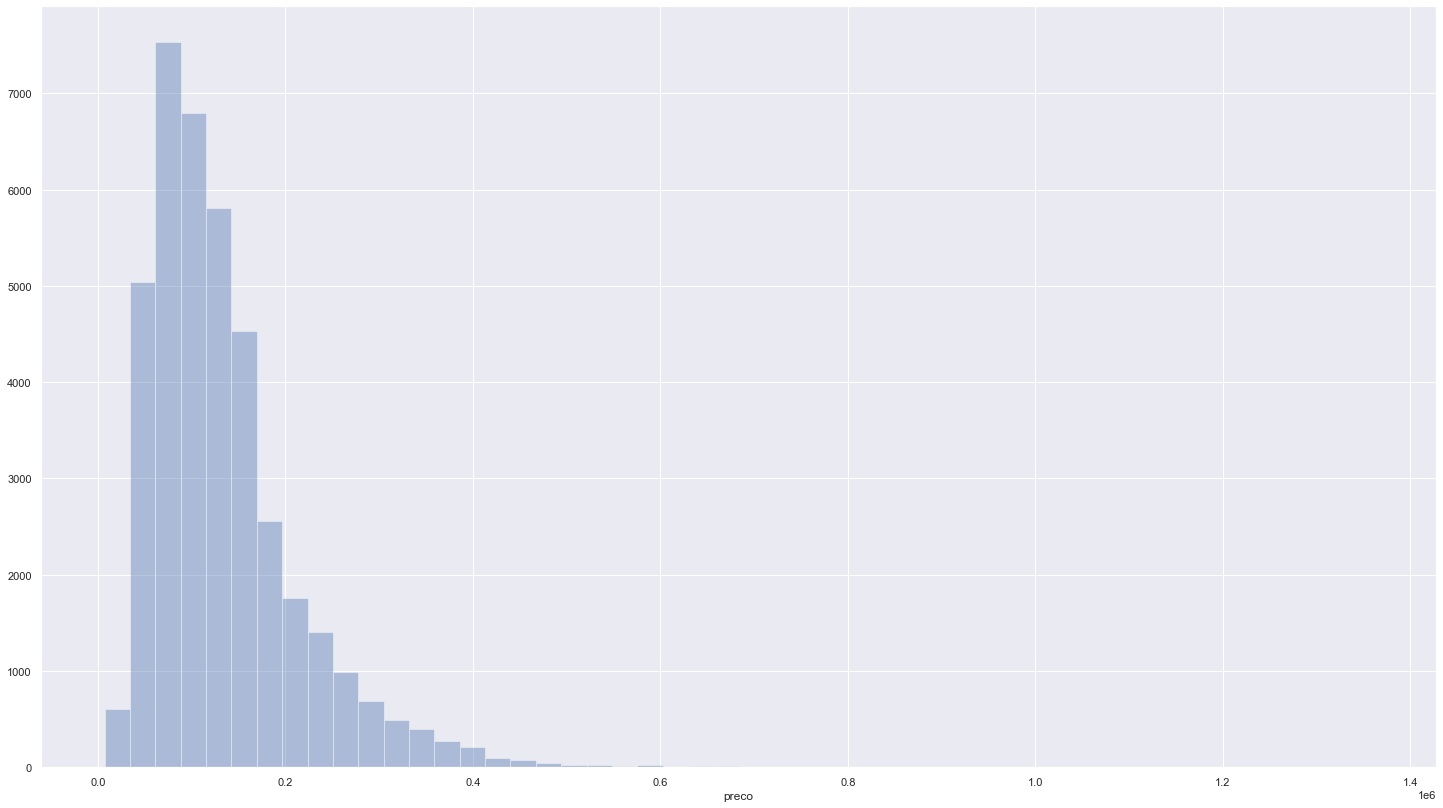

In [27]:
sns.distplot(df3['preco'], kde=False)

## 3.1.1 Numerical Variable

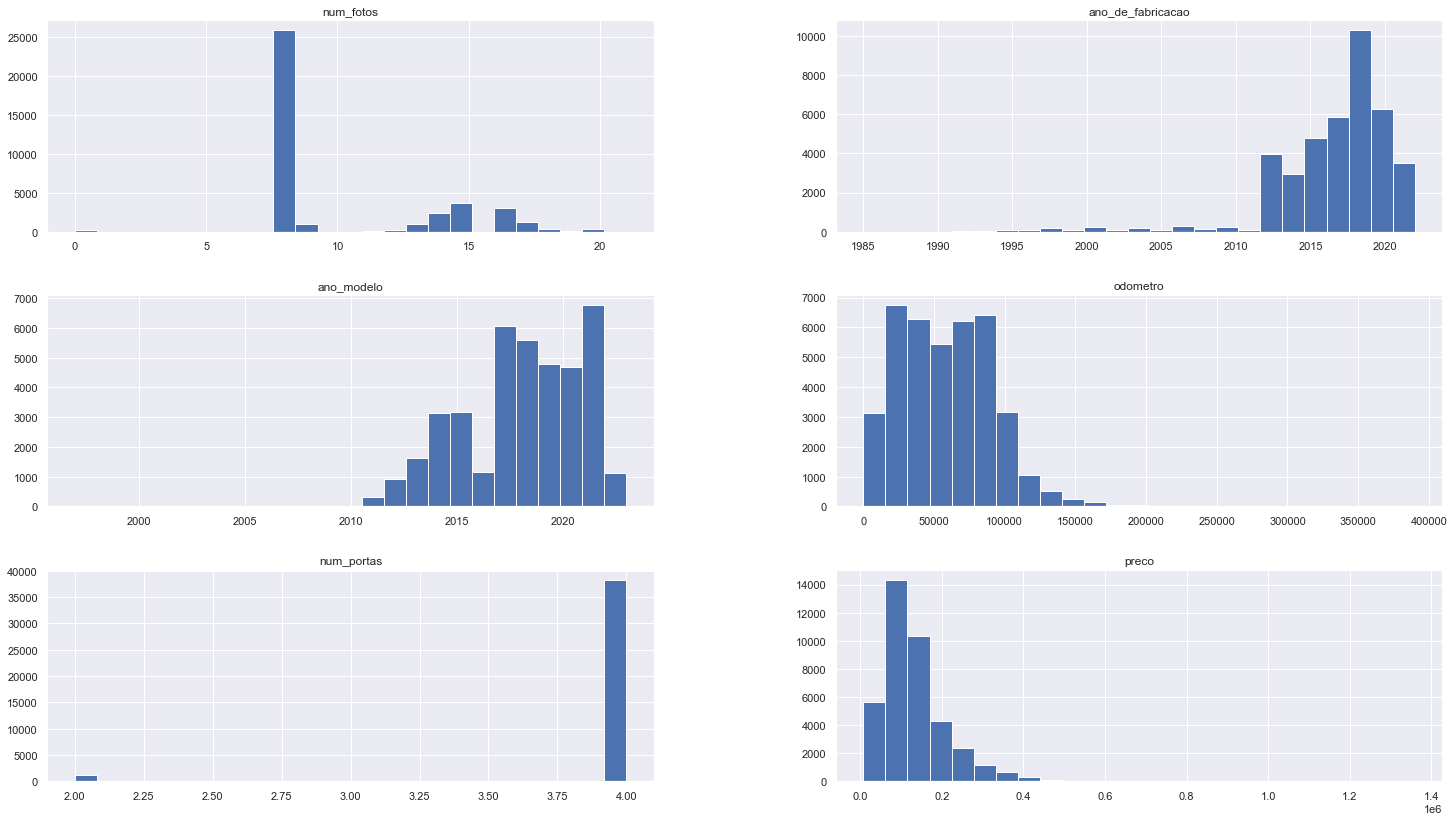

In [28]:
num_attributes.hist( bins=25 );

## 3.1.2 Categorical Variable

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                                                            39446
marca                                                            41
modelo                                                          473
versao                                                         2058
cambio                                                            7
tipo                                                              8
blindado                                                          2
cor                                                               8
tipo_vendedor                                                     2
cidade_vendedor                                                 648
estado_vendedor                                                  25
tipo_anuncio                                                      4
entrega_delivery                                                  2
troca                                                             2
elegivel_revisao                                

In [30]:
df3['marca'].value_counts()

VOLKSWAGEN       6140
CHEVROLET        4020
TOYOTA           2882
HYUNDAI          2740
JEEP             2667
FIAT             2523
BMW              2375
AUDI             2291
PEUGEOT          2246
HONDA            2097
MERCEDES-BENZ    1501
FORD             1445
MITSUBISHI       1148
LAND ROVER       1027
RENAULT           711
NISSAN            583
KIA               565
PORSCHE           470
VOLVO             363
CITROËN           248
TROLLER           223
RAM               221
JAGUAR            212
CHERY             202
MINI              182
LEXUS              91
SUBARU             54
SUZUKI             51
DODGE              47
CHRYSLER           40
SSANGYONG          20
SMART              16
MASERATI           12
LIFAN              10
ALFA ROMEO         10
JAC                 5
FERRARI             2
EFFA                2
IVECO               2
BRM                 1
LAMBORGHINI         1
Name: marca, dtype: int64

In [31]:
df3['modelo'].value_counts()

COMPASS                 1967
2008                    1924
Q3                      1213
TORO                    1179
COROLLA                 1168
ONIX                    1140
320i                    1082
AMAROK                   958
GOLF                     924
HILUX                    856
CIVIC                    830
CRUZE                    817
POLO                     789
JETTA                    695
HB20S                    621
RENEGADE                 582
STRADA                   553
HB20                     513
MONTANA                  481
VIRTUS                   479
T-CROSS                  469
HILUX SW4                465
IX35                     459
FIT                      441
A3                       414
RANGER                   412
CRETA                    408
ECOSPORT                 400
TIGUAN                   393
HR-V                     388
SPORTAGE                 362
GOL                      361
DISCOVERY SPORT          358
S10                      333
ASX           

In [32]:
df3['versao'].value_counts()

1.6 16V FLEX ALLURE PACK 4P AUTOMÁTICO                                         1825
2.0 16V FLEX LIMITED AUTOMÁTICO                                                1355
2.0 TFSI AMBIENTE QUATTRO 4P GASOLINA S TRONIC                                 1007
1.0 200 TSI COMFORTLINE AUTOMÁTICO                                              624
2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIESEL 4P AUTOMÁTICO                  567
1.8 16V EVO FLEX FREEDOM AT6                                                    529
1.4 MPFI LS CS 8V FLEX 2P MANUAL                                                477
2.0 SPORT 16V TURBO ACTIVE FLEX 4P AUTOMÁTICO                                   445
2.0 XEI 16V FLEX 4P AUTOMÁTICO                                                  432
2.0 TSI GTI 16V TURBO GASOLINA 4P AUTOMÁTICO                                    415
1.4 MPI WORKING CS 8V FLEX 2P MANUAL                                            413
1.0 200 TSI TOTAL FLEX COMFORTLINE AUTOMÁTICO                               

In [33]:
df3['cambio'].value_counts()

Automática               30073
Manual                    6631
CVT                       2391
Automatizada               192
Automatizada DCT            71
Semi-automática             56
Automática Sequencial       32
Name: cambio, dtype: int64

In [34]:
df3['tipo'].value_counts()

Sedã                    21910
Hatchback                6570
Picape                   6426
Utilitário esportivo     4458
Perua/SW                   37
Cupê                       34
Minivan                    10
Conversível                 1
Name: tipo, dtype: int64

In [35]:
df3['cor'].value_counts()

Branco      27919
Preto        6985
Prata        2359
Cinza        2174
Dourado         6
Vermelho        1
Azul            1
Verde           1
Name: cor, dtype: int64

In [36]:
df3['cidade_vendedor'].value_counts()

São Paulo                       8198
Rio de Janeiro                  7739
Belo Horizonte                  2925
Presidente Prudente             2022
Goiânia                         1871
Medianeira                      1578
Campinas                        1088
São José do Rio Preto           1031
Porto Alegre                     892
Ribeirão Preto                   829
Salvador                         753
Recife                           661
São Bernardo do Campo            535
Santos                           535
Curitiba                         489
Jundiaí                          472
Fortaleza                        440
Mogi das Cruzes                  394
São José                         305
São Caetano do Sul               296
Barueri                          281
Praia Grande                     253
Maceió                           232
Sorocaba                         223
Florianópolis                    201
São José dos Campos              187
Joinville                        177
N

In [37]:
df3['estado_vendedor'].value_counts()

São Paulo (SP)              21794
Rio de Janeiro (RJ)          3384
Paraná (PR)                  3380
Santa Catarina (SC)          3119
Minas Gerais (MG)            2350
Rio Grande do Sul (RS)       2191
Goiás (GO)                   1043
Bahia (BA)                    827
Pernambuco (PE)               411
Alagoas (AL)                  171
Paraíba (PB)                  147
Rio Grande do Norte (RN)      119
Pará (PA)                     107
Ceará (CE)                     87
Amazonas (AM)                  66
Mato Grosso (MT)               48
Mato Grosso do Sul (MS)        46
Acre (AC)                      40
Tocantins (TO)                 34
Espírito Santo (ES)            29
Sergipe (SE)                   29
Piauí (PI)                      9
Maranhão (MA)                   7
Rondônia (RO)                   5
Roraima (RR)                    3
Name: estado_vendedor, dtype: int64

In [38]:
df3['tipo_anuncio'].value_counts()

Pessoa Física                       23949
Loja                                13182
Concessionária                       2310
Acessórios e serviços para autos        5
Name: tipo_anuncio, dtype: int64

## 3.2 Análise Bivariada

- Hipóteses

1. Quanto mais recente o modelo do carro mais caro o carro é.

2. Se o carro for blindado mais caro é o carro.

3. Carros com cores neutras vendem mais que carros com outras cores

4. Carros com cambio automaticos são mais caros que outros

5. Carros com maior quilometragem vendem menos

6. Carros da região sudeste tendem a ter um valor médio maior que outra regiões

7. Carros que tiveram um unico dono tendem um valor mais alto

8. Carros com todas revisões feitas em concessionária

9. Carros com maior exposição tendem vender mais

10. Carros com garatia de fábrica tendem a ter um valor mais caro.

11. Carros com ipva pago tem um valor mais alto

12. Carros vendidos em lojas são mais caros que vendidos por pessoa fisica.

13. Carros com licenciamento pago tendem a ter um valor mais caro

### 3.2.1 H1

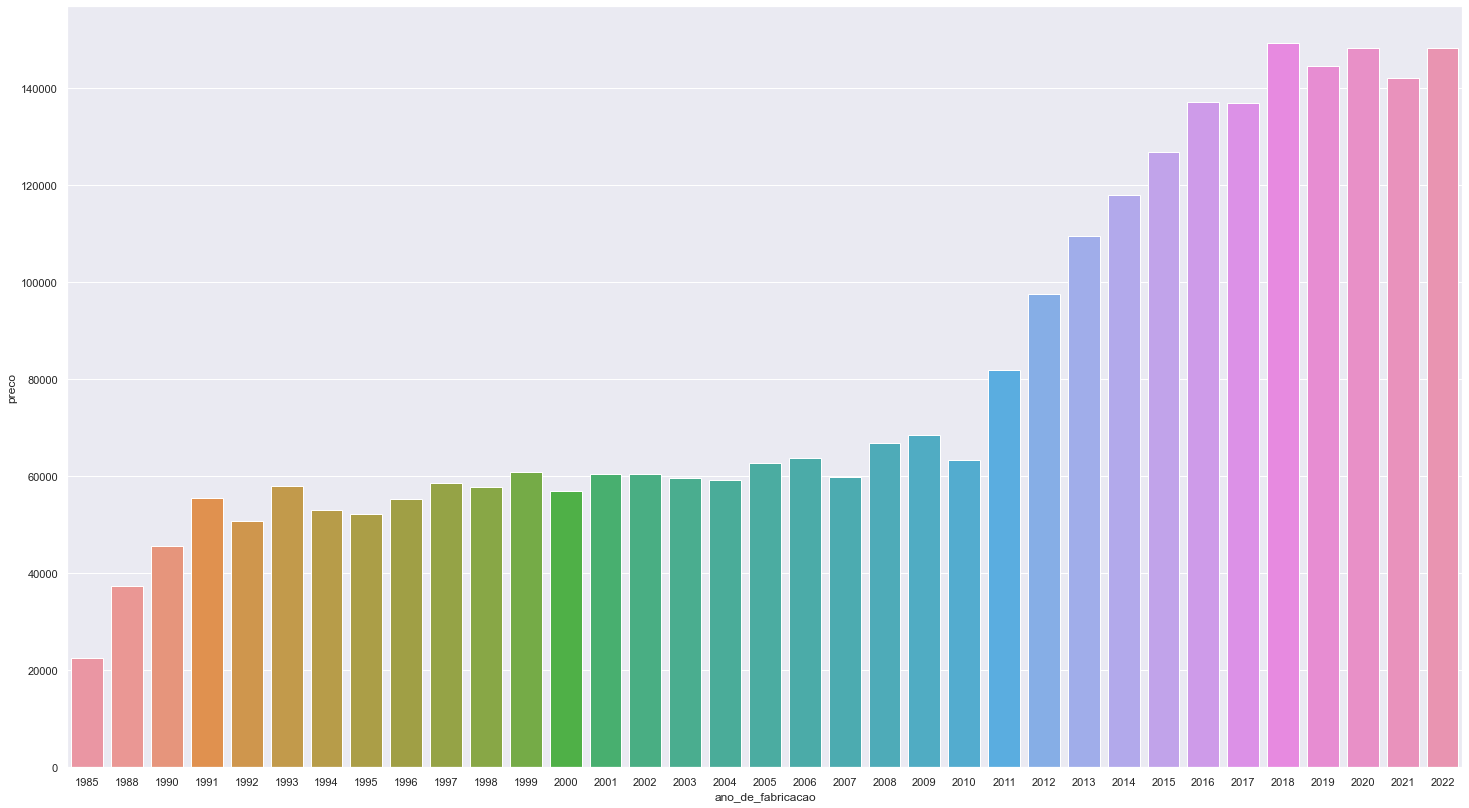

In [39]:
aux = df3[['preco', 'ano_de_fabricacao']].groupby('ano_de_fabricacao').mean().reset_index()
sns.barplot(x='ano_de_fabricacao', y='preco', data=aux);

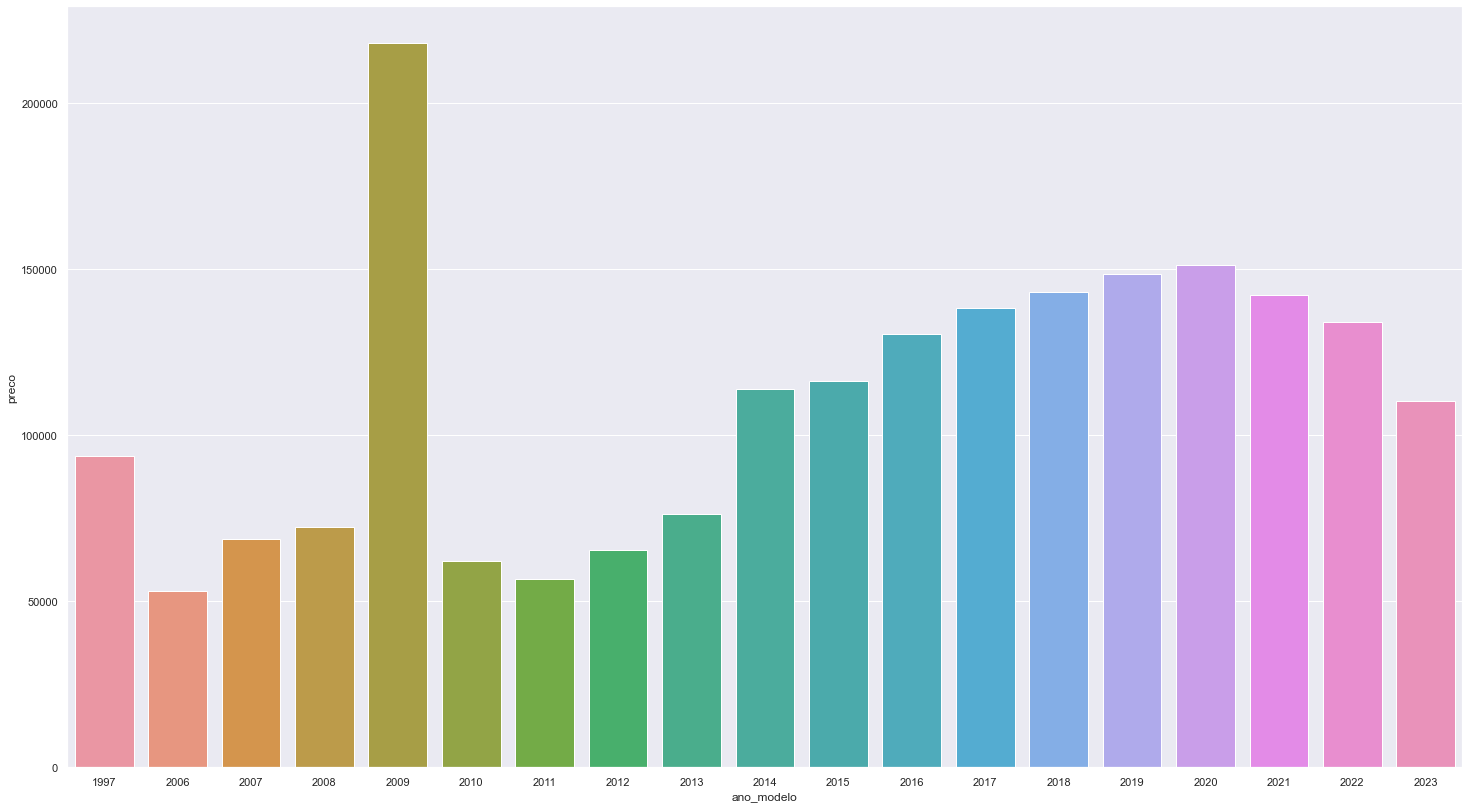

In [40]:
aux = df3[['preco', 'ano_modelo']].groupby('ano_modelo').mean().reset_index()
sns.barplot(x='ano_modelo', y='preco', data=aux);

In [41]:
aux = df3[df3['ano_modelo'] == 2009]

<AxesSubplot:xlabel='marca', ylabel='preco'>

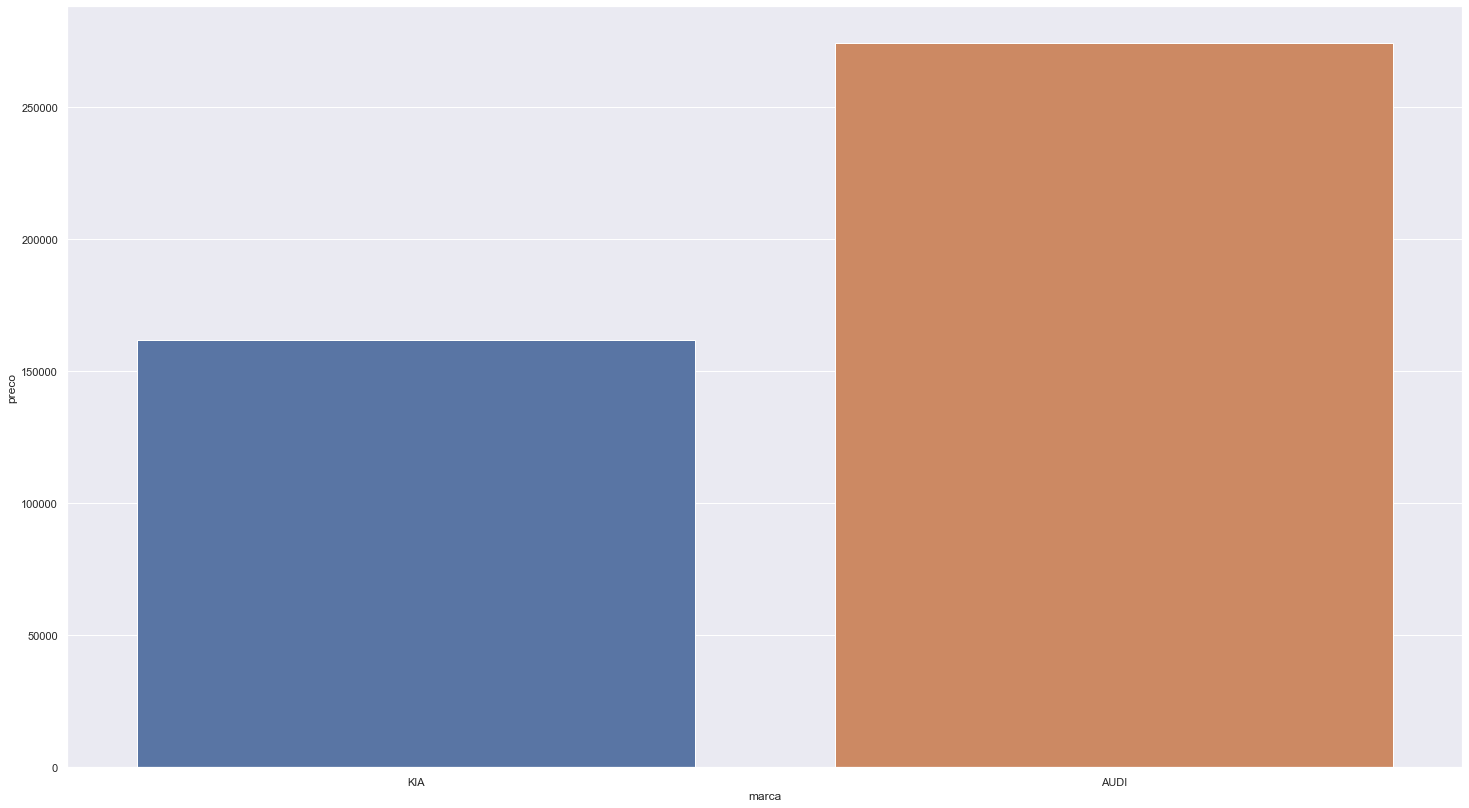

In [42]:
aux00 = df3[['preco', 'marca']].groupby('marca').mean().reset_index()
sns.barplot(x = 'marca', y='preco', data=aux)

### 3.2.2 H2

- Se o carro for blindado mais caro é o carro.

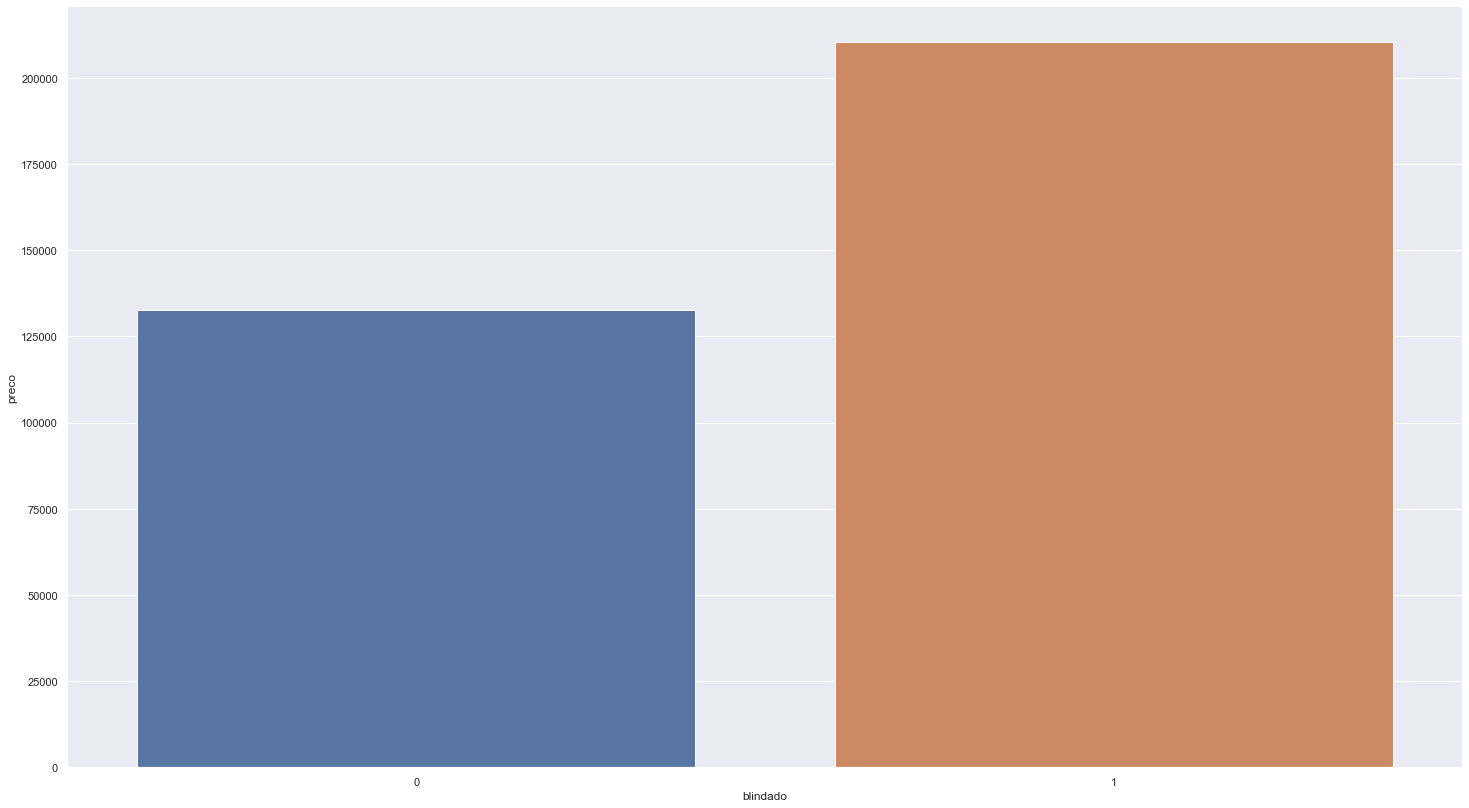

In [43]:
aux = df3[['preco', 'blindado']].groupby('blindado').mean().reset_index()
sns.barplot(x='blindado', y='preco', data=aux);

### 3.2.3 H3

- Carros com cores neutras vendem mais que carros com outras cores

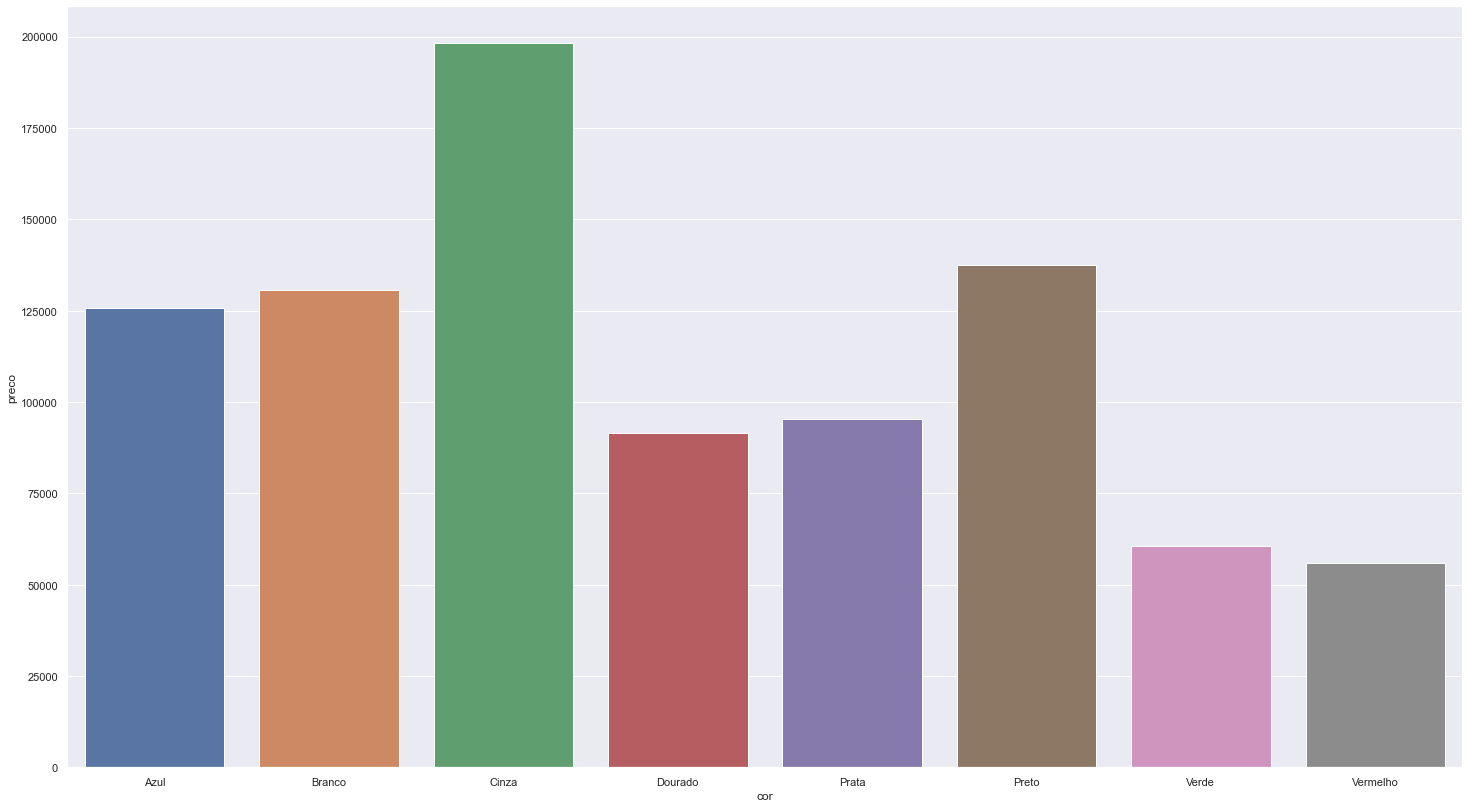

In [44]:
aux = df3[['preco', 'cor']].groupby('cor').mean().reset_index()
sns.barplot(x='cor', y='preco', data=aux);

### 3.2.4 H4

- Carros com cambio automaticos são mais caros que outros

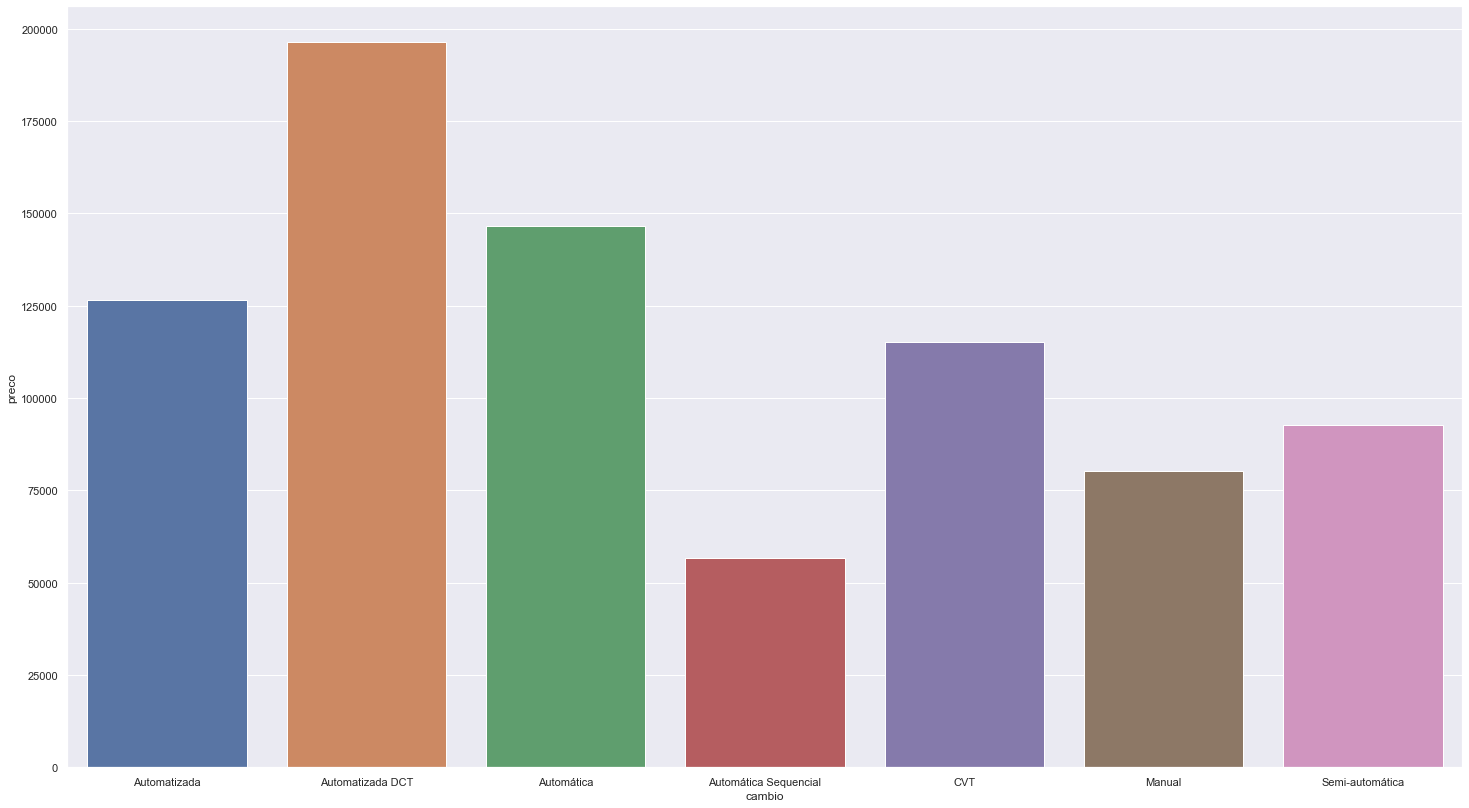

In [45]:
aux = df3[['preco', 'cambio']].groupby('cambio').mean().reset_index()
sns.barplot(x='cambio', y='preco', data=aux);

### 3.2.5 H5

- Carros com maior quilometragem vendem menos

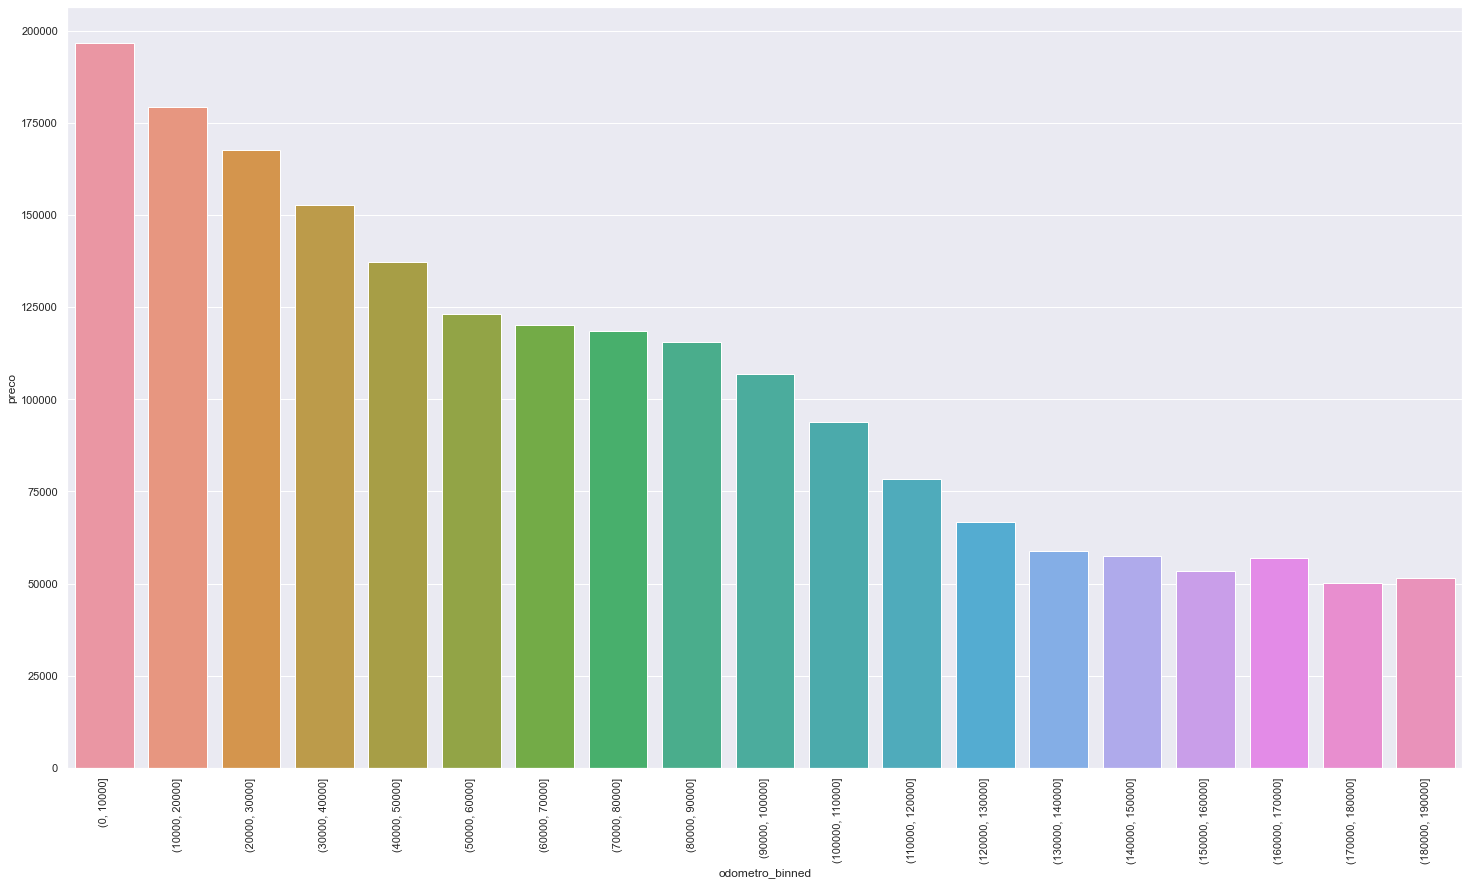

In [46]:
aux_4=df3[['odometro', 'preco']].groupby ('odometro').mean().reset_index()

bins=list(np.arange(0,200000,10000))
aux_4['odometro_binned']=pd.cut(aux_4['odometro'], bins=bins)
aux_5=aux_4[['odometro_binned', 'preco']].groupby('odometro_binned').mean().reset_index()

sns.barplot(x='odometro_binned', y='preco', data=aux_5);
plt.xticks(rotation=90);

### 3.2.6 H6

- Carros da região sudeste tendem a ter um valor médio maior que outra regiões

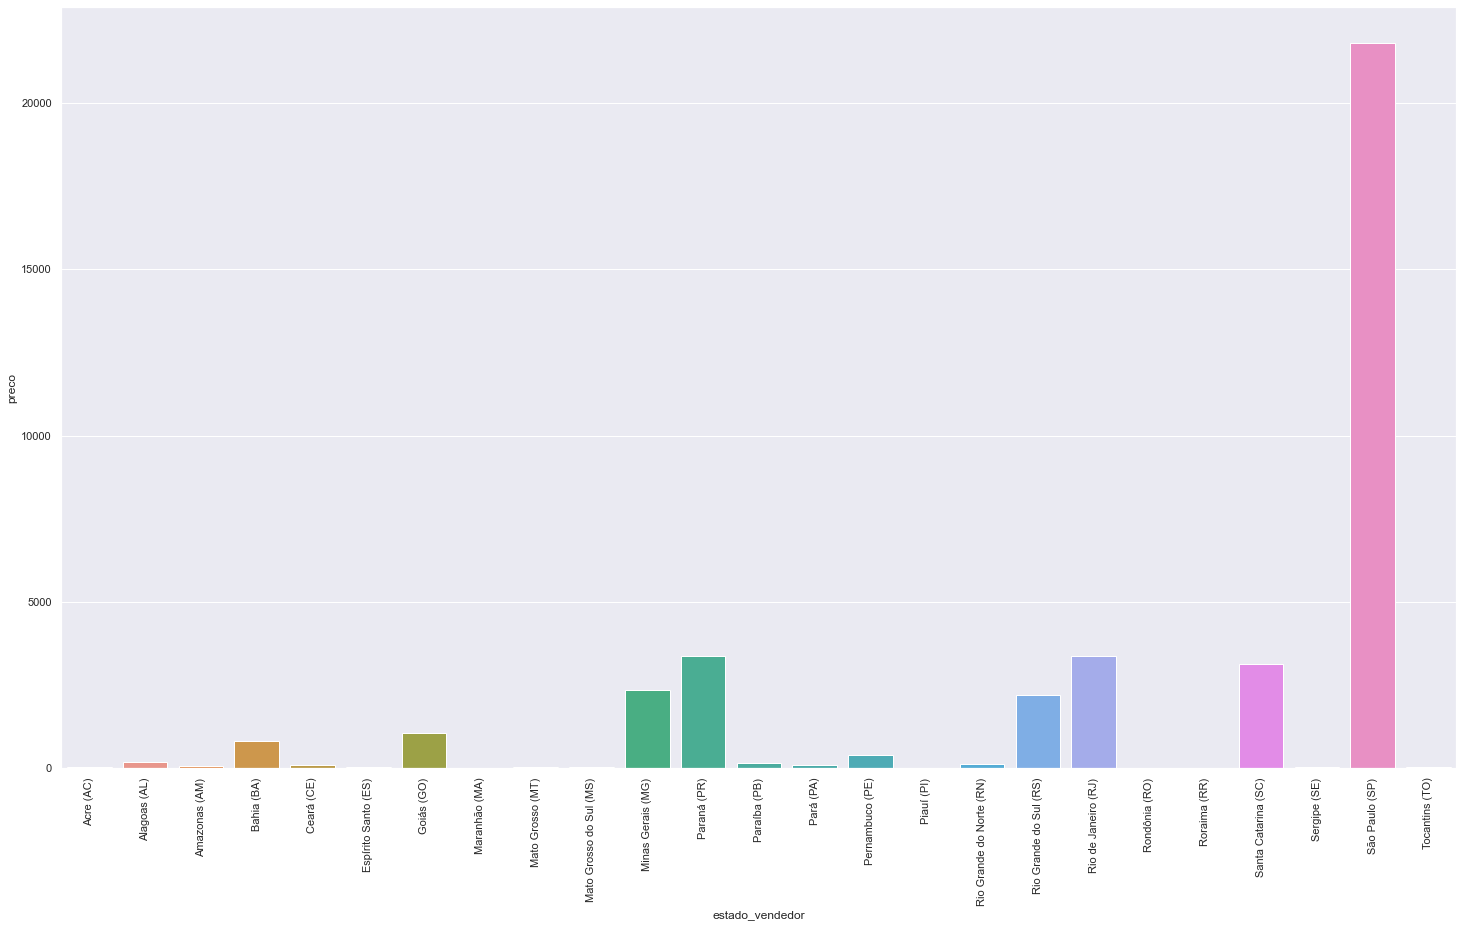

In [47]:
aux = df3[['estado_vendedor','preco']].groupby('estado_vendedor').count().reset_index()
sns.barplot(x='estado_vendedor', y='preco', data=aux);
plt.xticks(rotation=90);

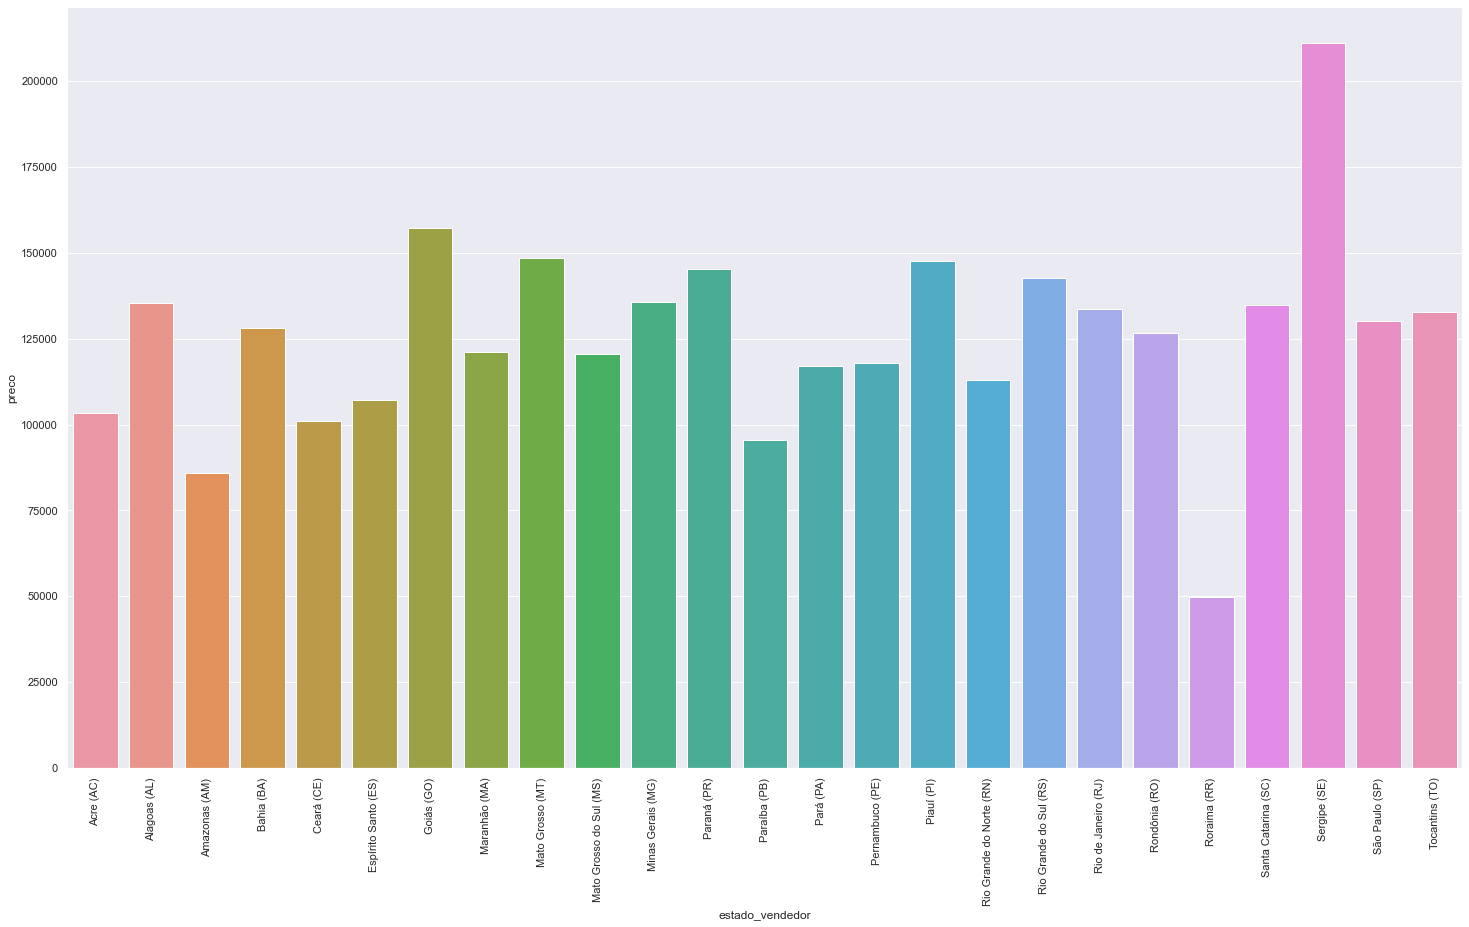

In [48]:
aux = df3[['estado_vendedor','preco']].groupby('estado_vendedor').mean().reset_index()
sns.barplot(x='estado_vendedor', y='preco', data=aux);
plt.xticks(rotation=90);

### 3.2.7 H7

- Carros que tiveram um unico dono tendem um valor mais alto

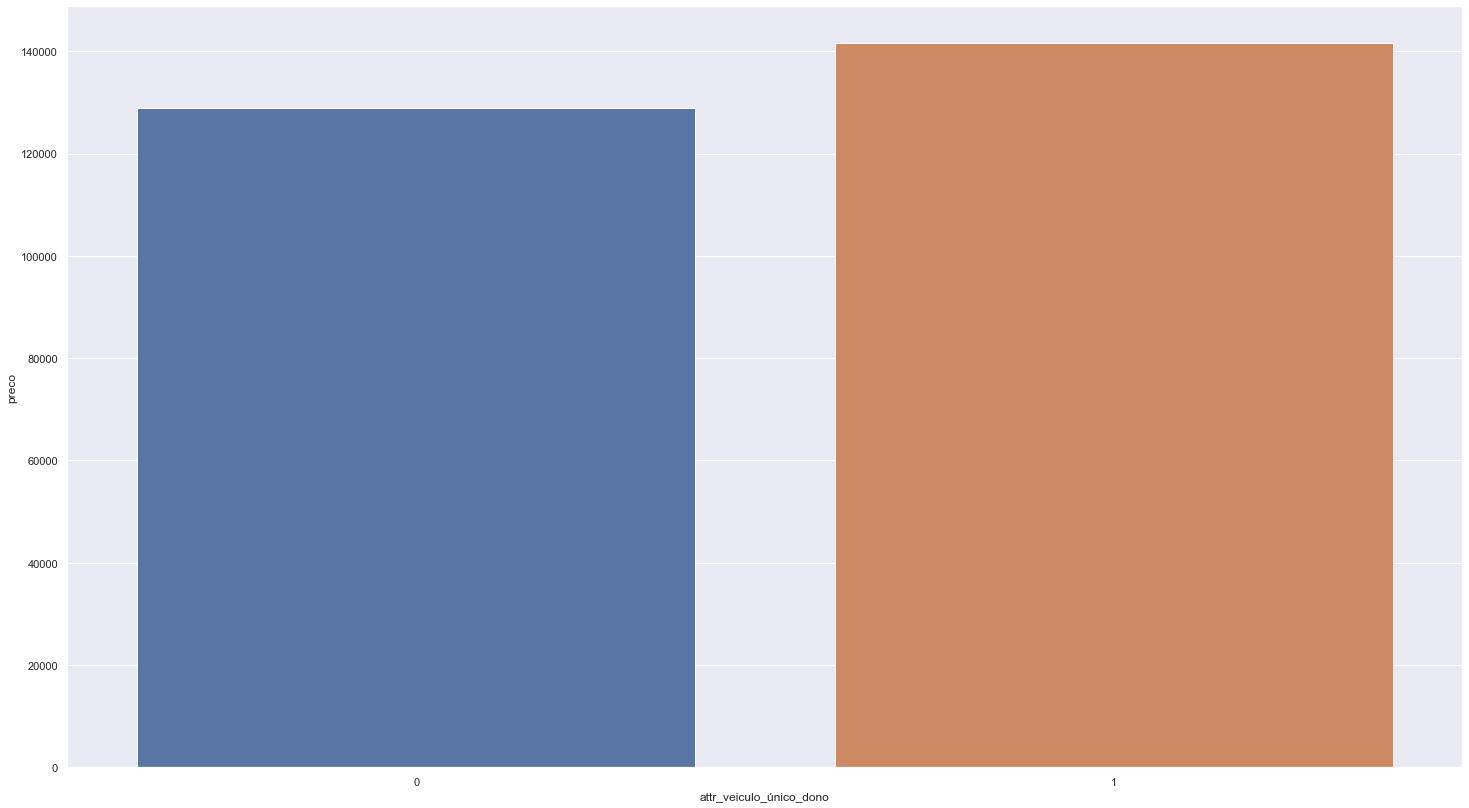

In [49]:
aux = df3[['preco', 'attr_veiculo_único_dono']].groupby('attr_veiculo_único_dono').mean().reset_index()
sns.barplot(x='attr_veiculo_único_dono', y='preco', data=aux);

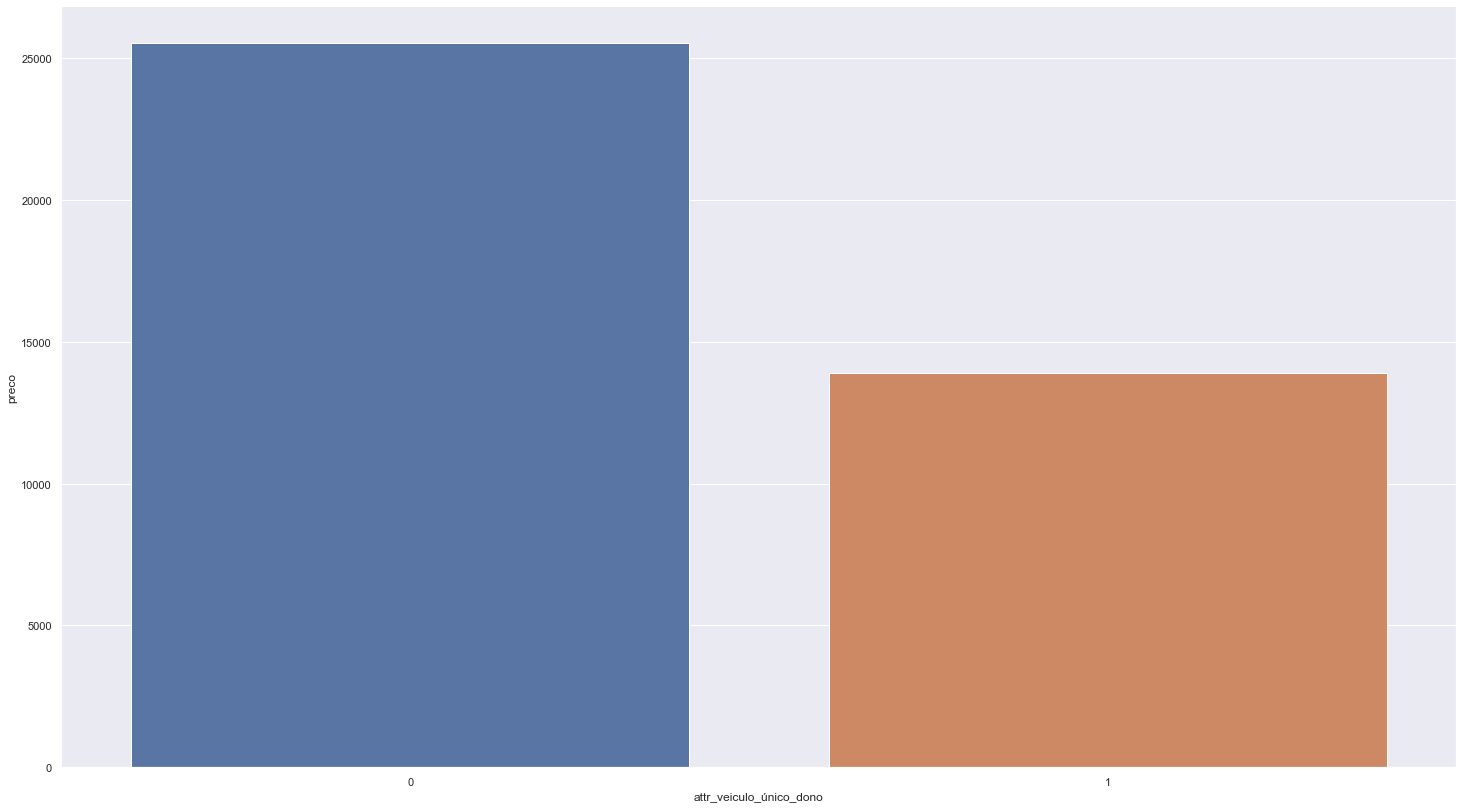

In [50]:
aux = df3[['preco', 'attr_veiculo_único_dono']].groupby('attr_veiculo_único_dono').count().reset_index()
sns.barplot(x='attr_veiculo_único_dono', y='preco', data=aux);

### 3.2.8 H8

- Carros com todas revisões feitas em concessionária tendem a ter um valor mais alto

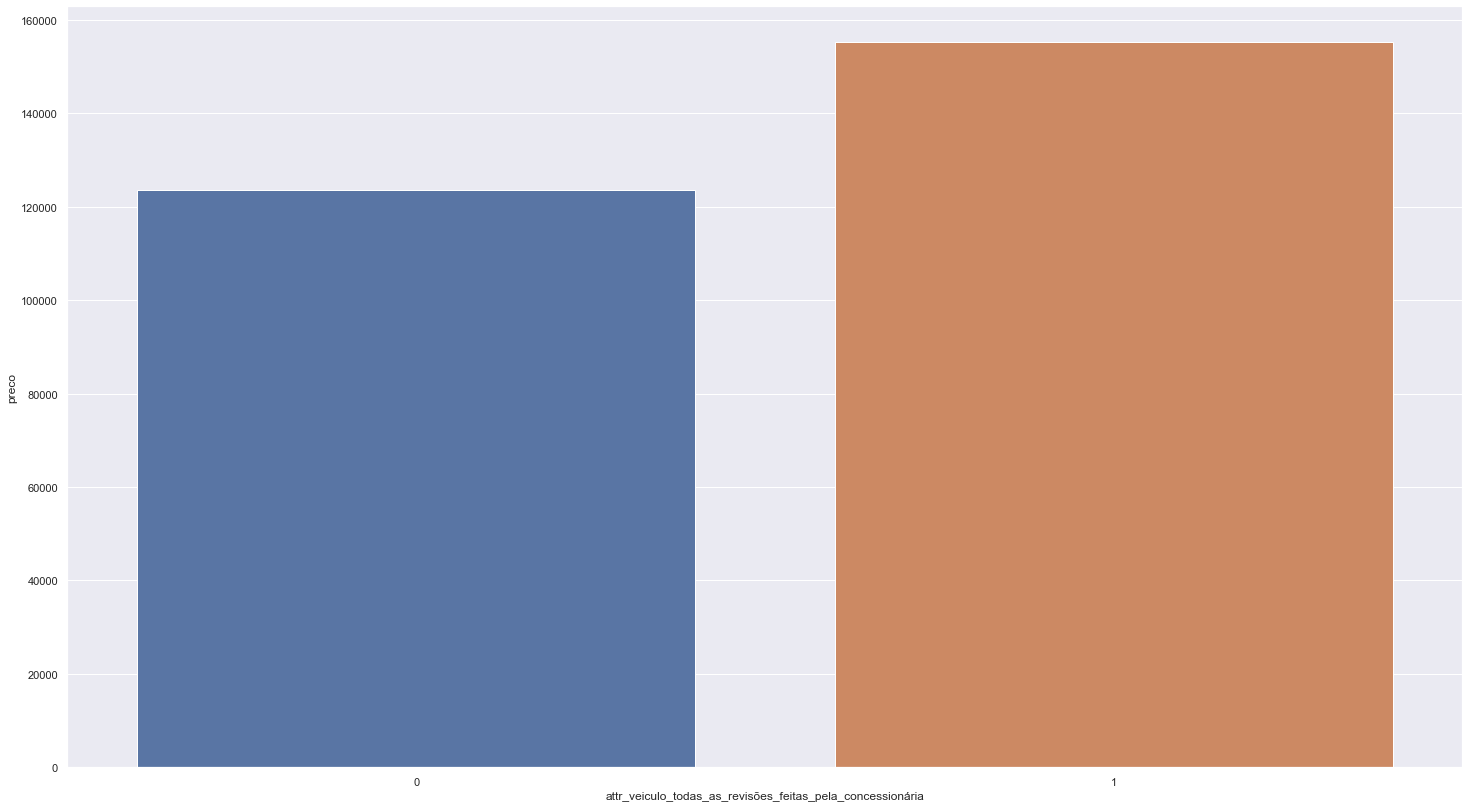

In [51]:
aux = df3[['preco', 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária']].groupby('attr_veiculo_todas_as_revisões_feitas_pela_concessionária').mean().reset_index()
sns.barplot(x='attr_veiculo_todas_as_revisões_feitas_pela_concessionária', y='preco', data=aux);

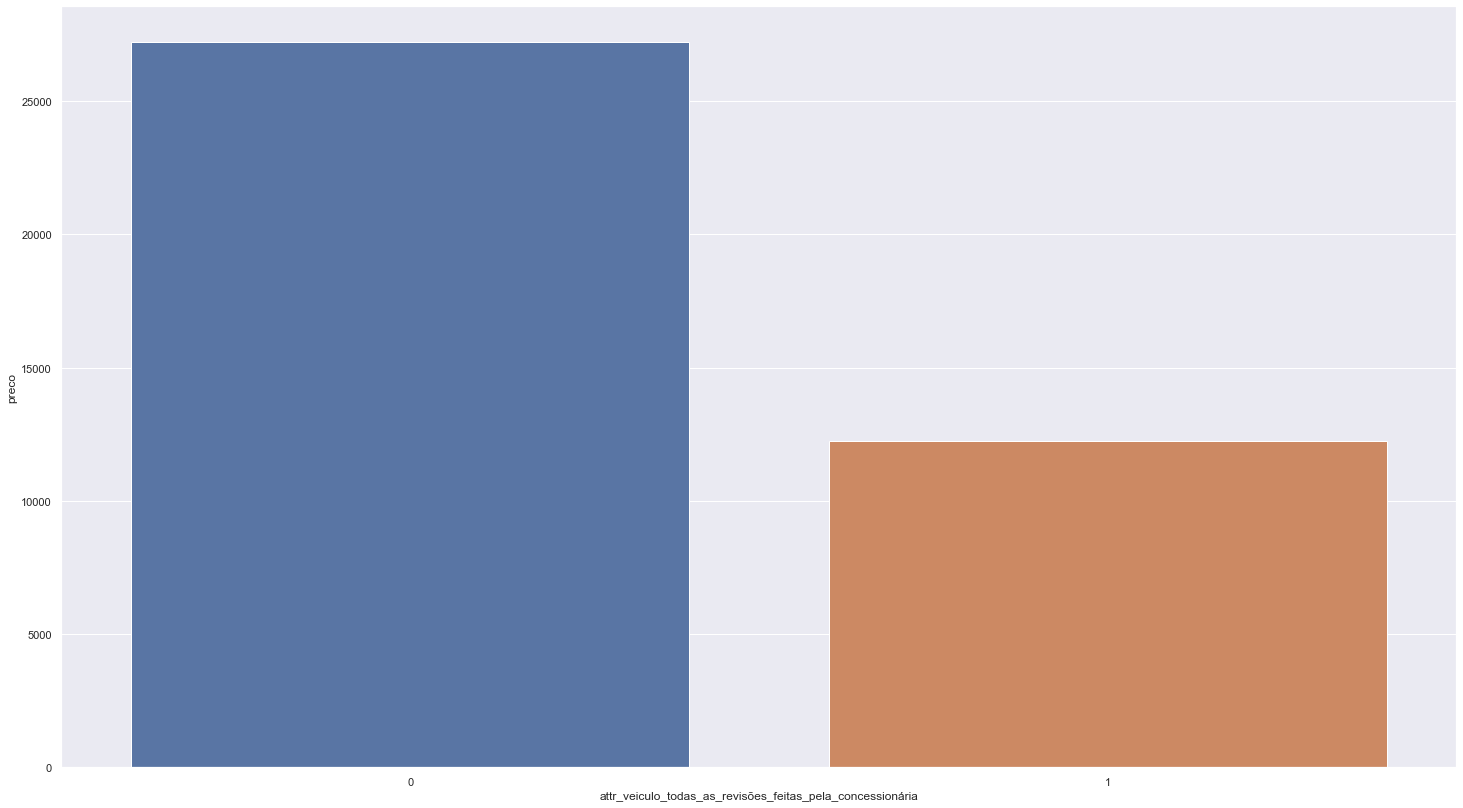

In [52]:
aux = df3[['preco', 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária']].groupby('attr_veiculo_todas_as_revisões_feitas_pela_concessionária').count().reset_index()
sns.barplot(x='attr_veiculo_todas_as_revisões_feitas_pela_concessionária', y='preco', data=aux);

### 3.2.9 H9

- Carros com maior exposição tendem a ter um valor mais alto

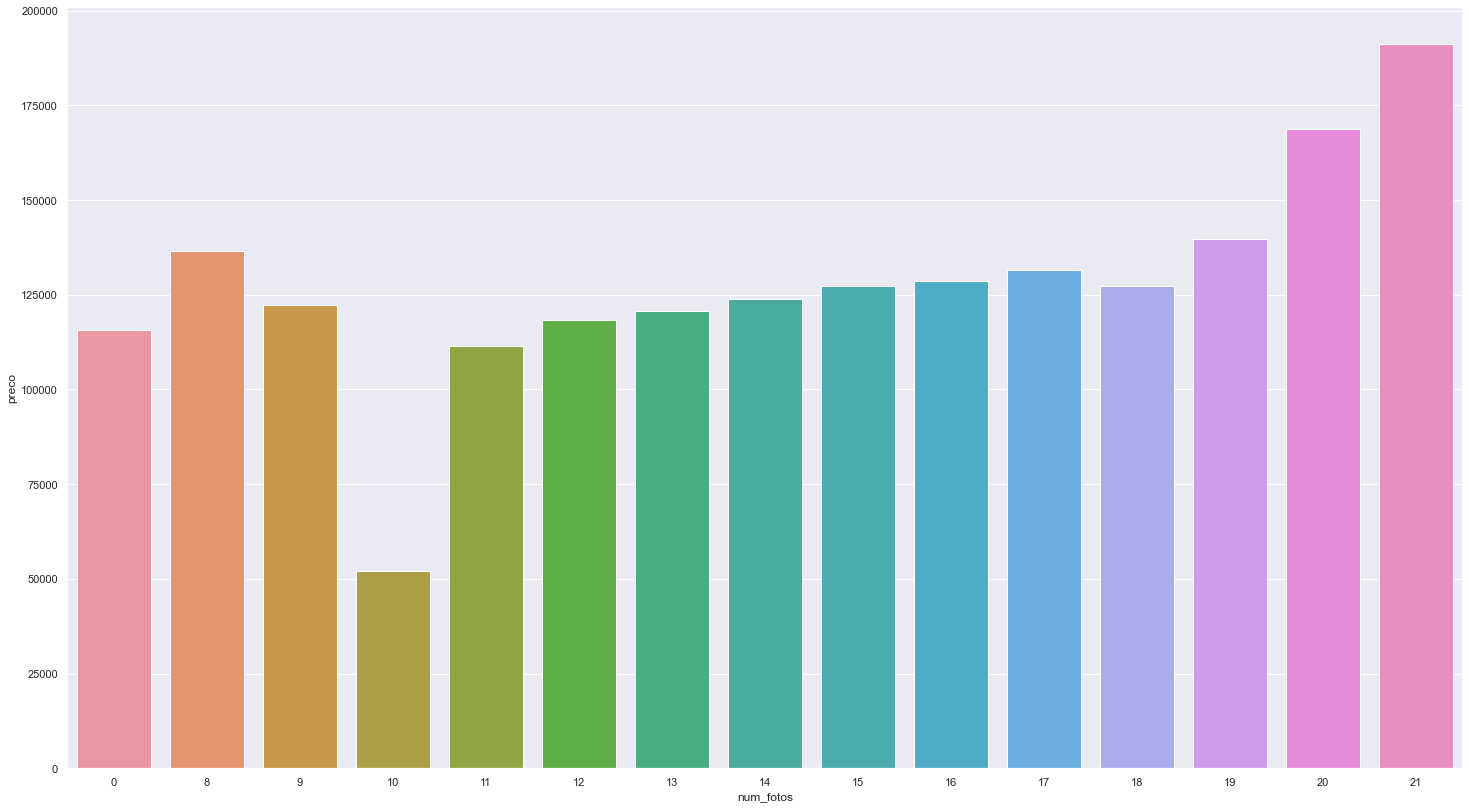

In [53]:
aux = df3[['preco', 'num_fotos']].groupby('num_fotos').mean().reset_index()
sns.barplot(x='num_fotos', y='preco', data=aux);

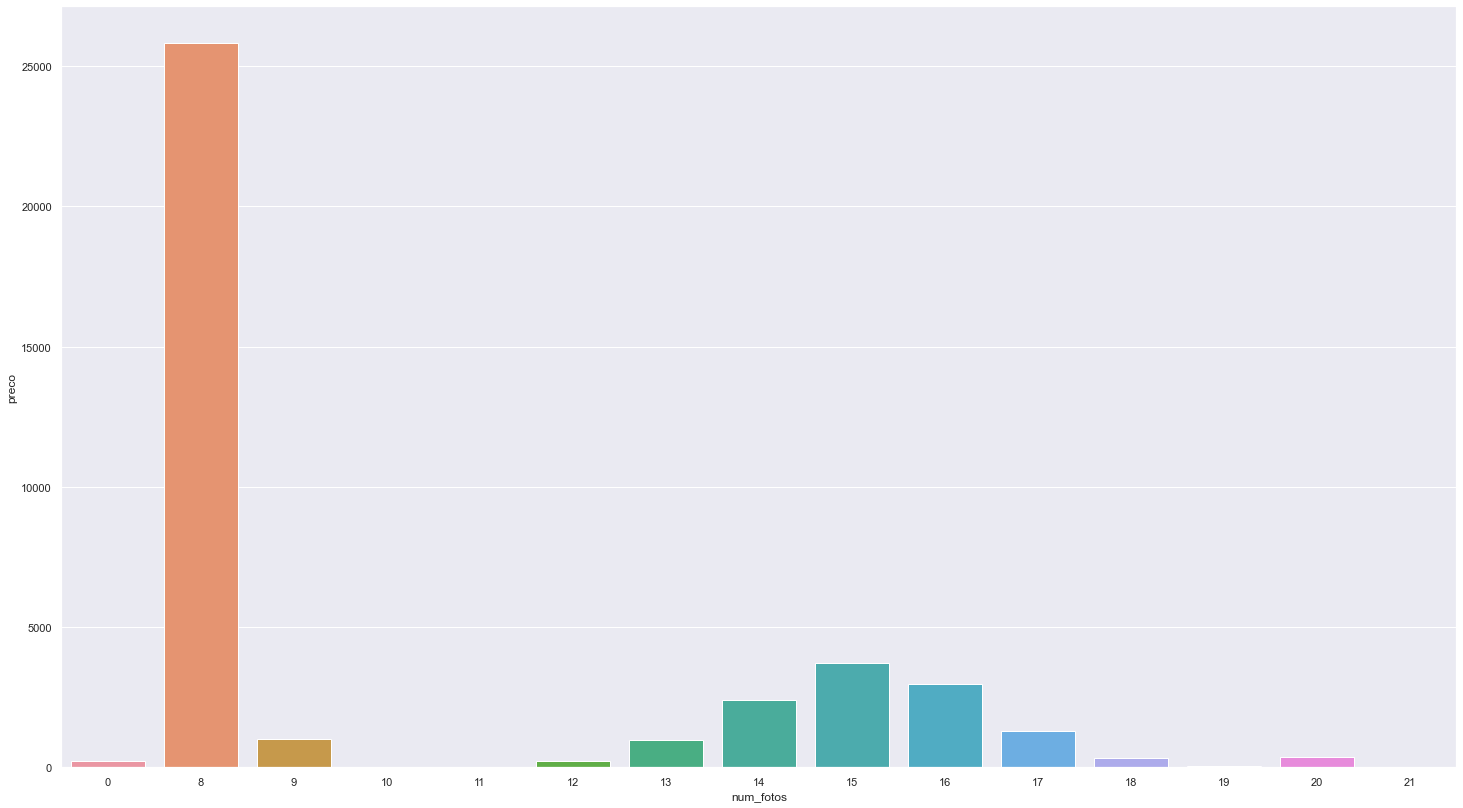

In [54]:
aux = df3[['preco', 'num_fotos']].groupby('num_fotos').count().reset_index()
sns.barplot(x='num_fotos', y='preco', data=aux);

### 3.2.10 H10

- Carros com garantia de fábrica tendem a ter um valor mais caro.

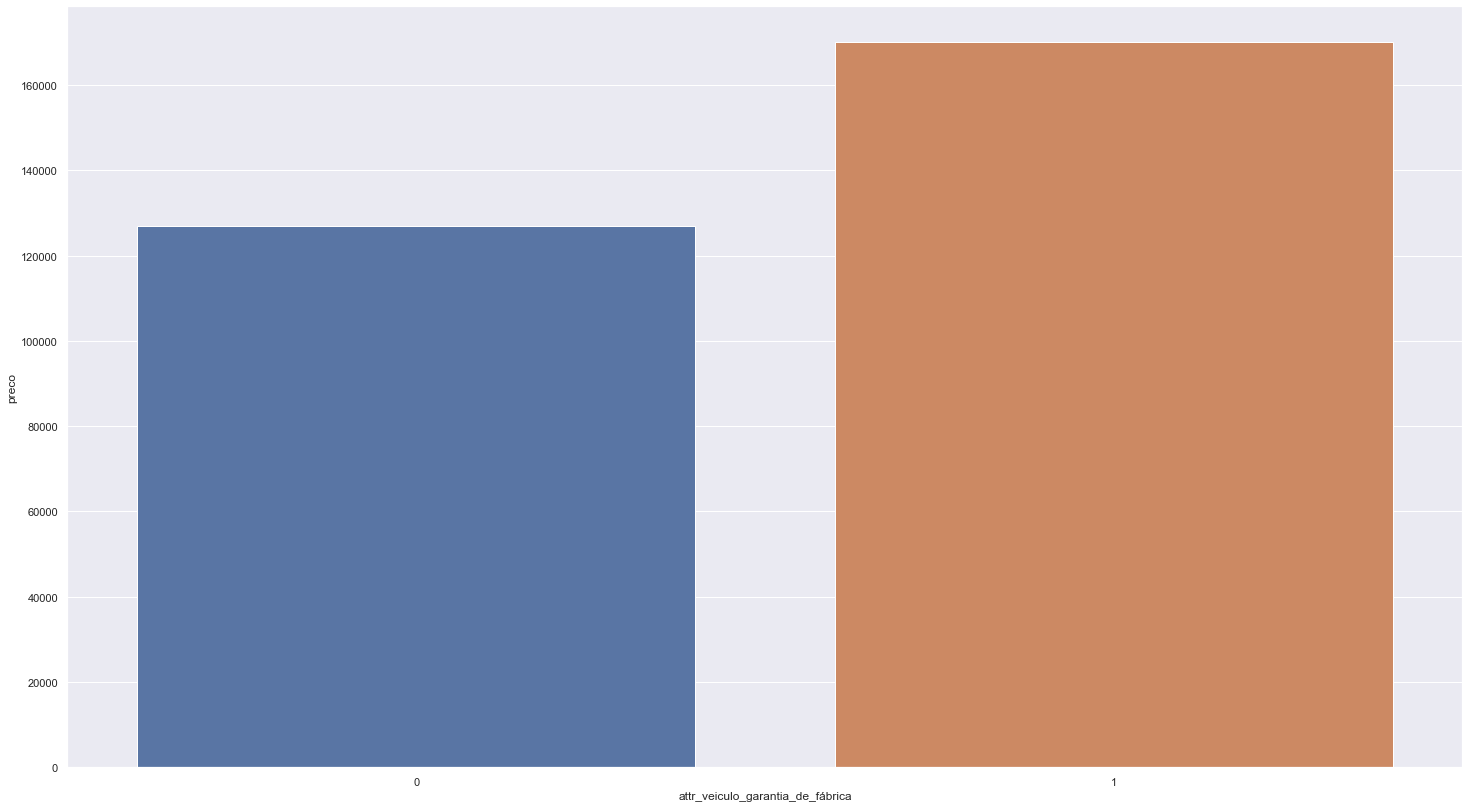

In [55]:
aux = df3[['preco', 'attr_veiculo_garantia_de_fábrica']].groupby('attr_veiculo_garantia_de_fábrica').mean().reset_index()
sns.barplot(x='attr_veiculo_garantia_de_fábrica', y='preco', data=aux);

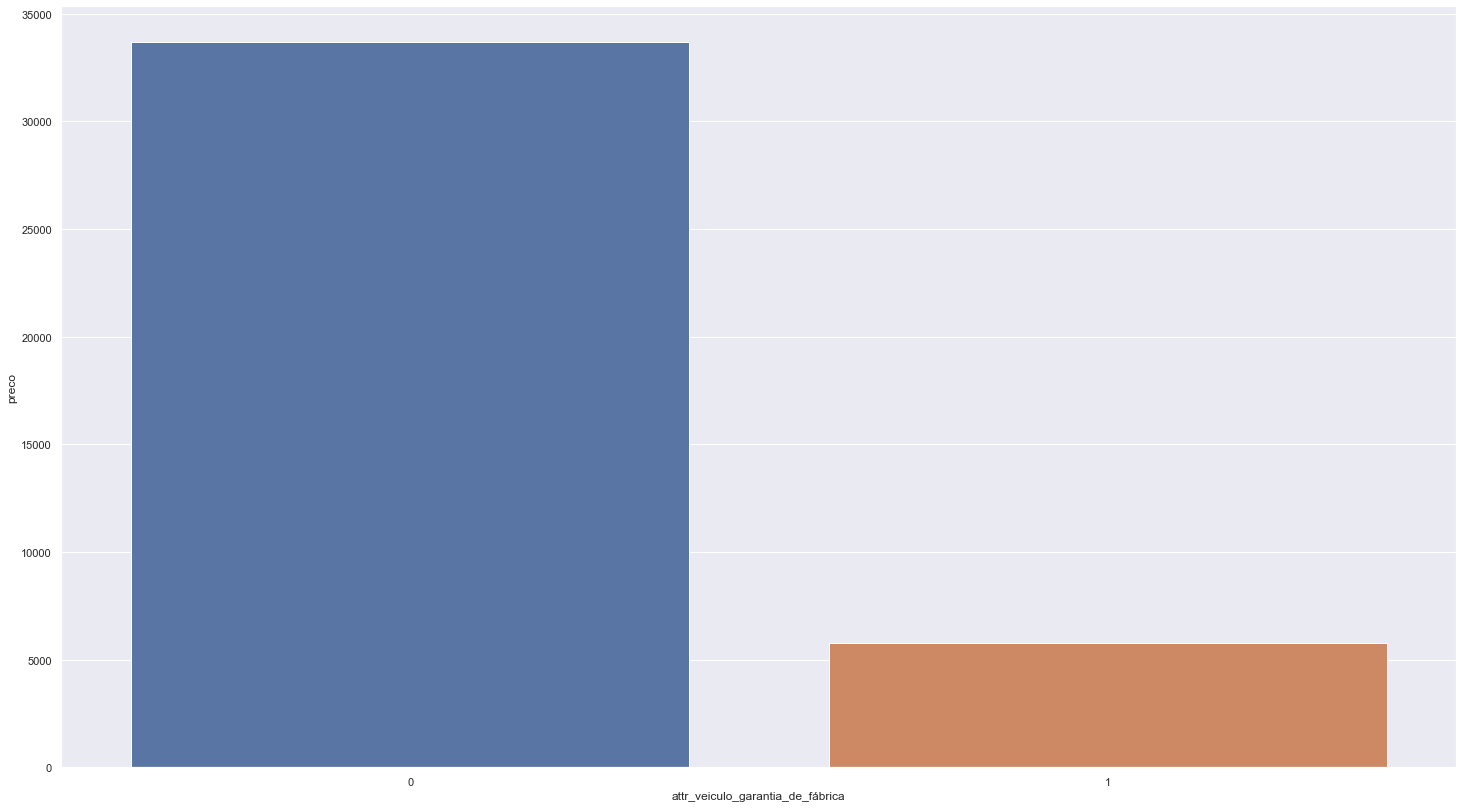

In [56]:
aux = df3[['preco', 'attr_veiculo_garantia_de_fábrica']].groupby('attr_veiculo_garantia_de_fábrica').count().reset_index()
sns.barplot(x='attr_veiculo_garantia_de_fábrica', y='preco', data=aux);

### 3.2.11 H11

- Carros com ipva pago tem um valor mais alto

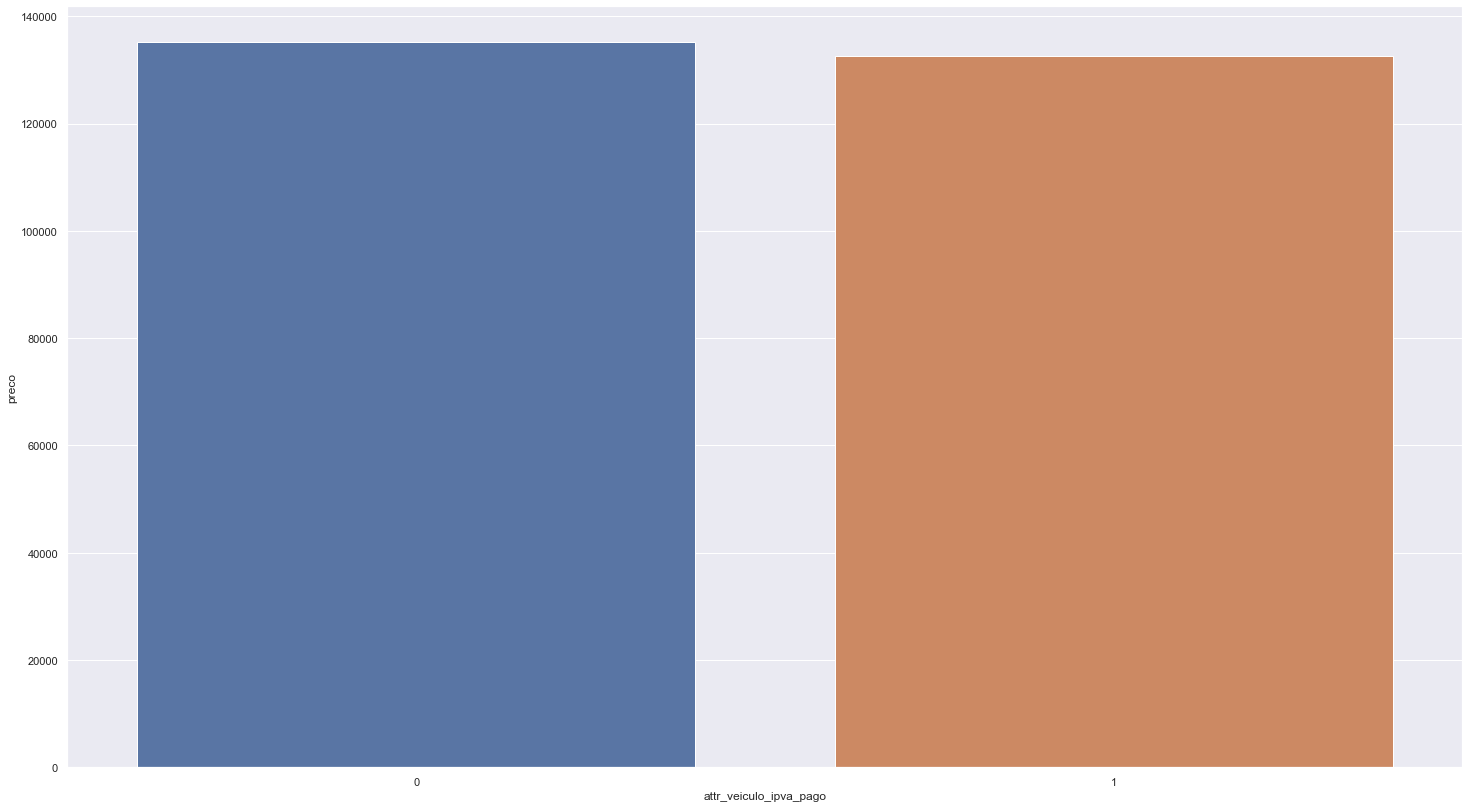

In [57]:
aux = df3[['preco', 'attr_veiculo_ipva_pago']].groupby('attr_veiculo_ipva_pago').mean().reset_index()
sns.barplot(x='attr_veiculo_ipva_pago', y='preco', data=aux);

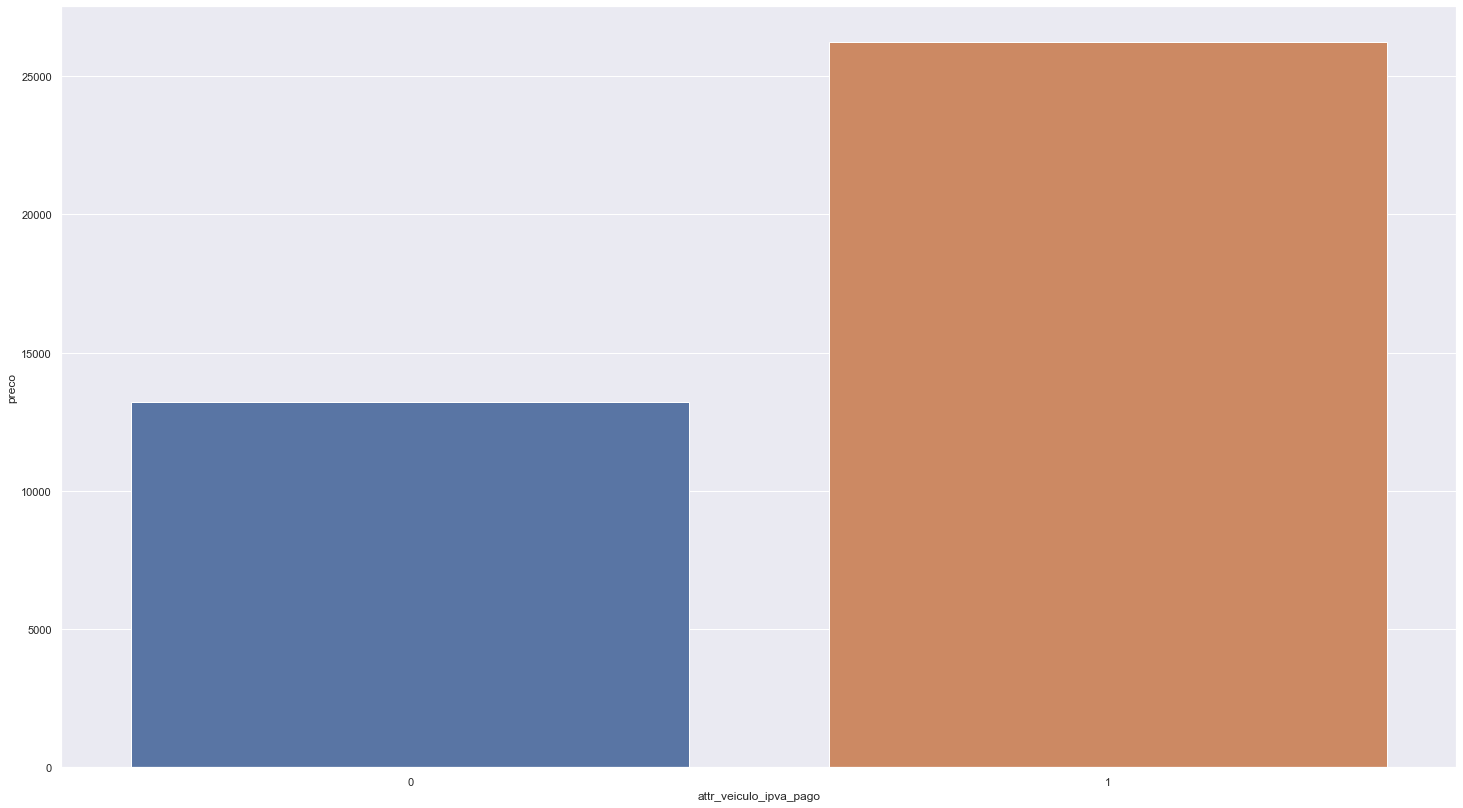

In [58]:
aux = df3[['preco', 'attr_veiculo_ipva_pago']].groupby('attr_veiculo_ipva_pago').count().reset_index()
sns.barplot(x='attr_veiculo_ipva_pago', y='preco', data=aux);

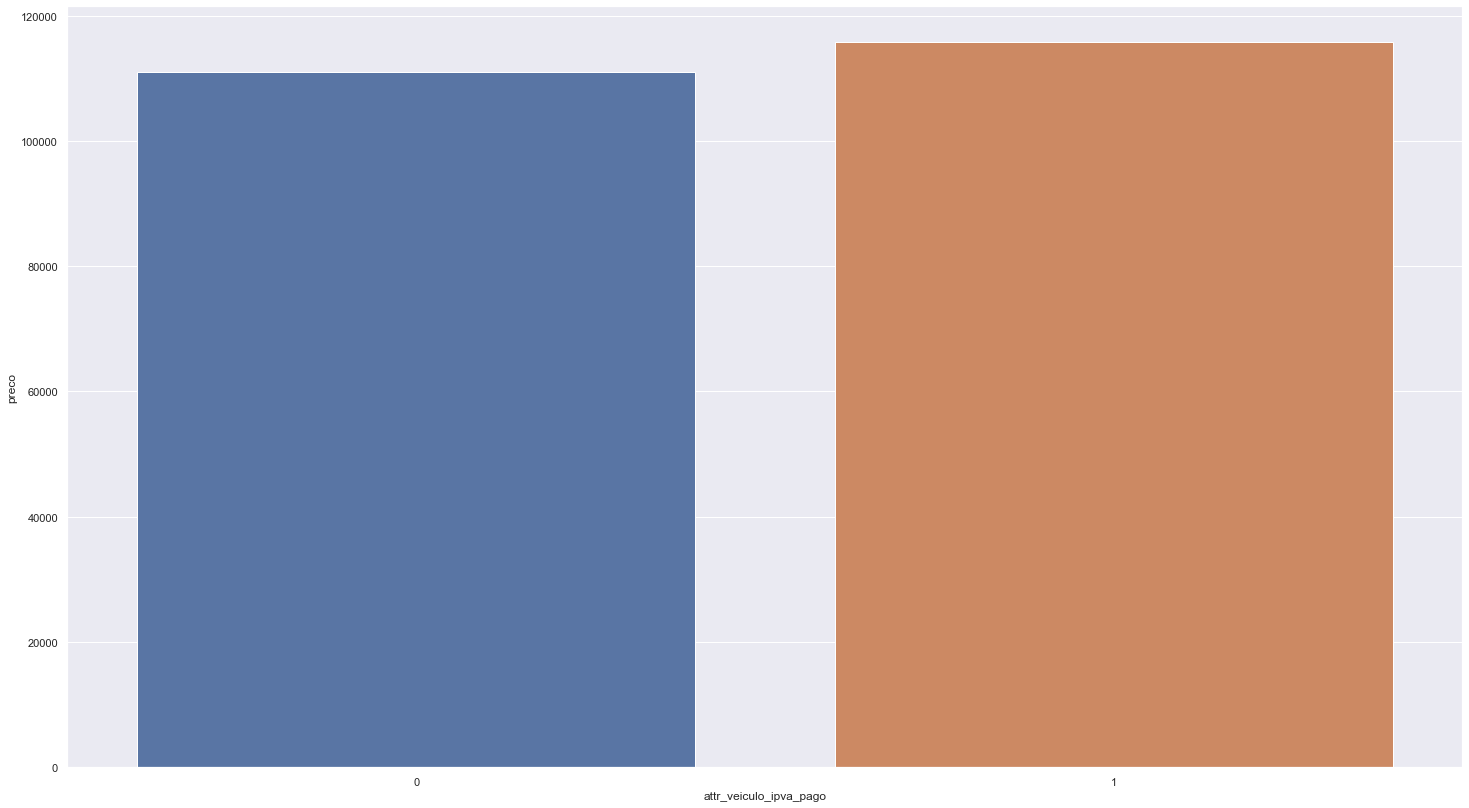

In [59]:
aux = df3[['preco', 'attr_veiculo_ipva_pago']].groupby('attr_veiculo_ipva_pago').median().reset_index()
sns.barplot(x='attr_veiculo_ipva_pago', y='preco', data=aux);

### 3.2.12 H12

- Carros vendidos em lojas são mais caros que vendidos por pessoa fisica.



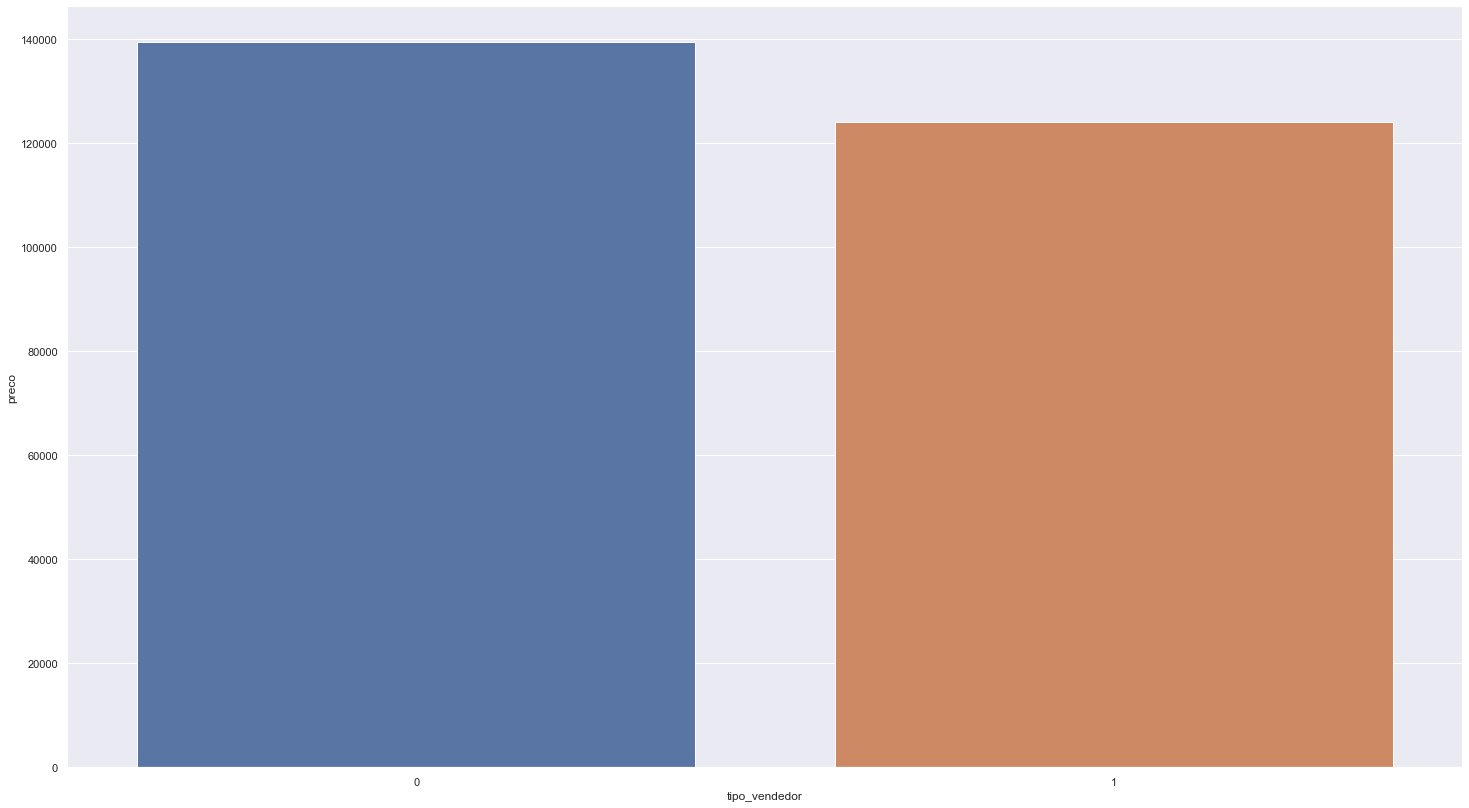

In [60]:
aux = df3[['preco', 'tipo_vendedor']].groupby('tipo_vendedor').mean().reset_index()
sns.barplot(x='tipo_vendedor', y='preco', data=aux);

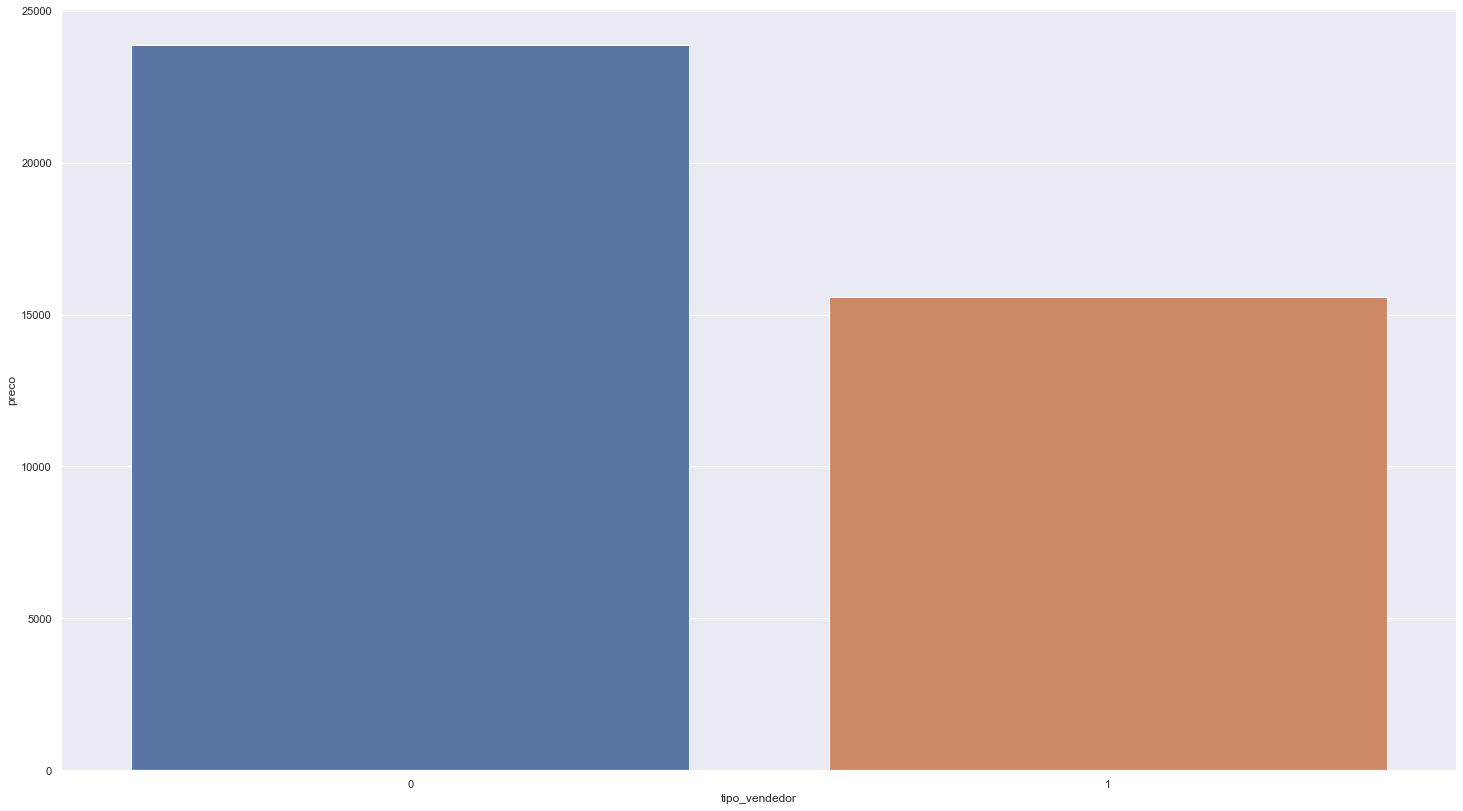

In [61]:
aux = df3[['preco', 'tipo_vendedor']].groupby('tipo_vendedor').count().reset_index()
sns.barplot(x='tipo_vendedor', y='preco', data=aux);

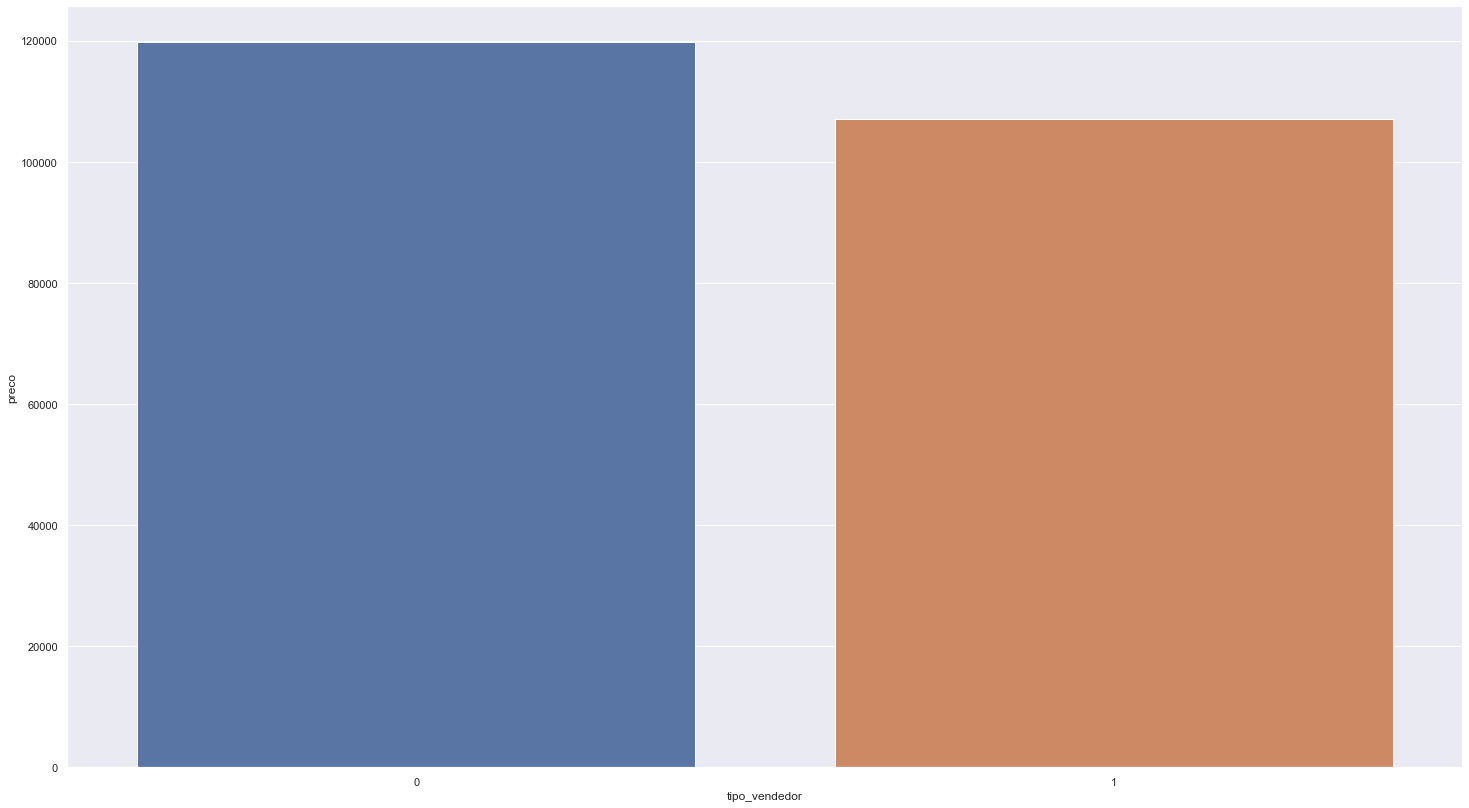

In [62]:
aux = df3[['preco', 'tipo_vendedor']].groupby('tipo_vendedor').median().reset_index()
sns.barplot(x='tipo_vendedor', y='preco', data=aux);

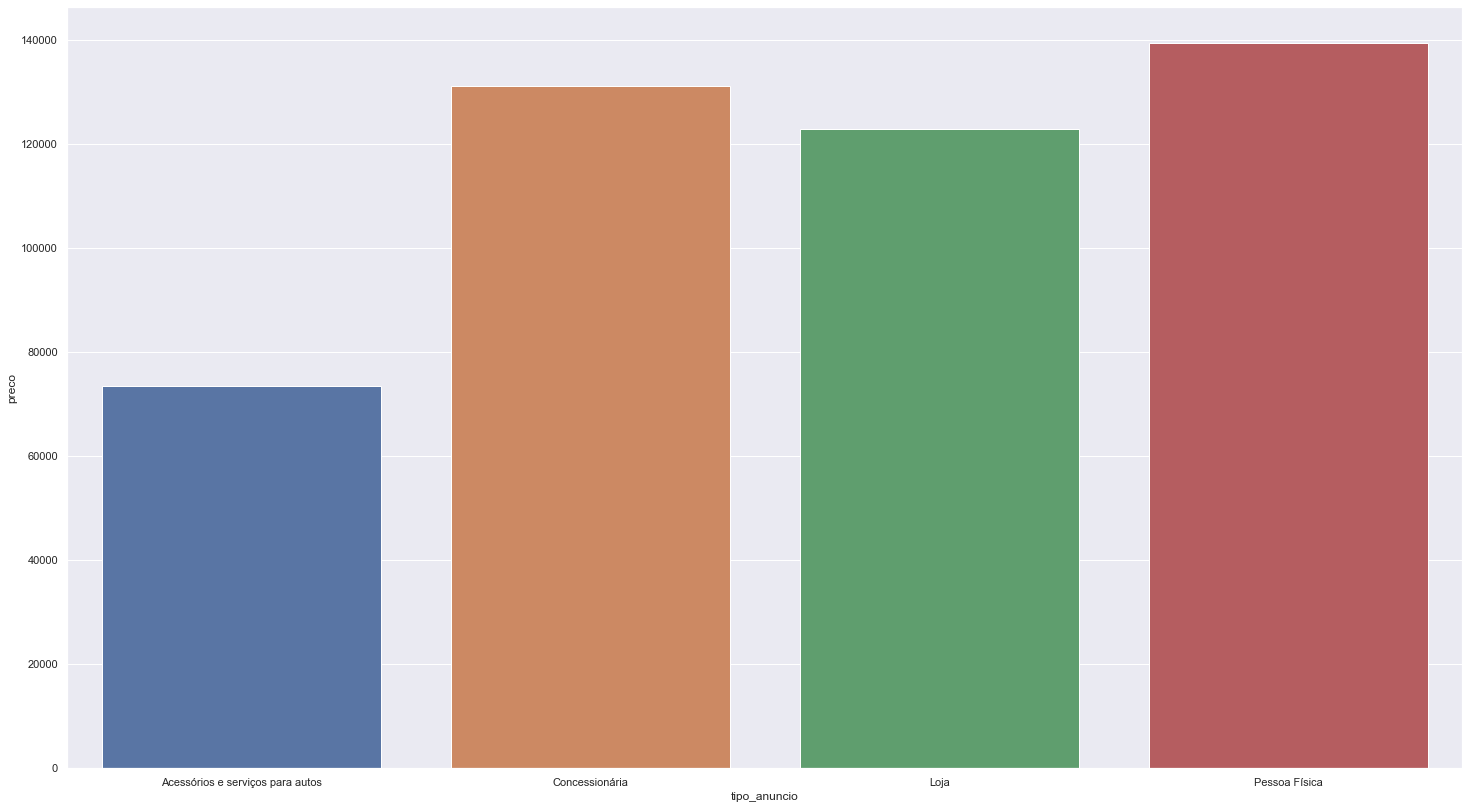

In [63]:
aux = df3[['preco', 'tipo_anuncio']].groupby('tipo_anuncio').mean().reset_index()
sns.barplot(x='tipo_anuncio', y='preco', data=aux);

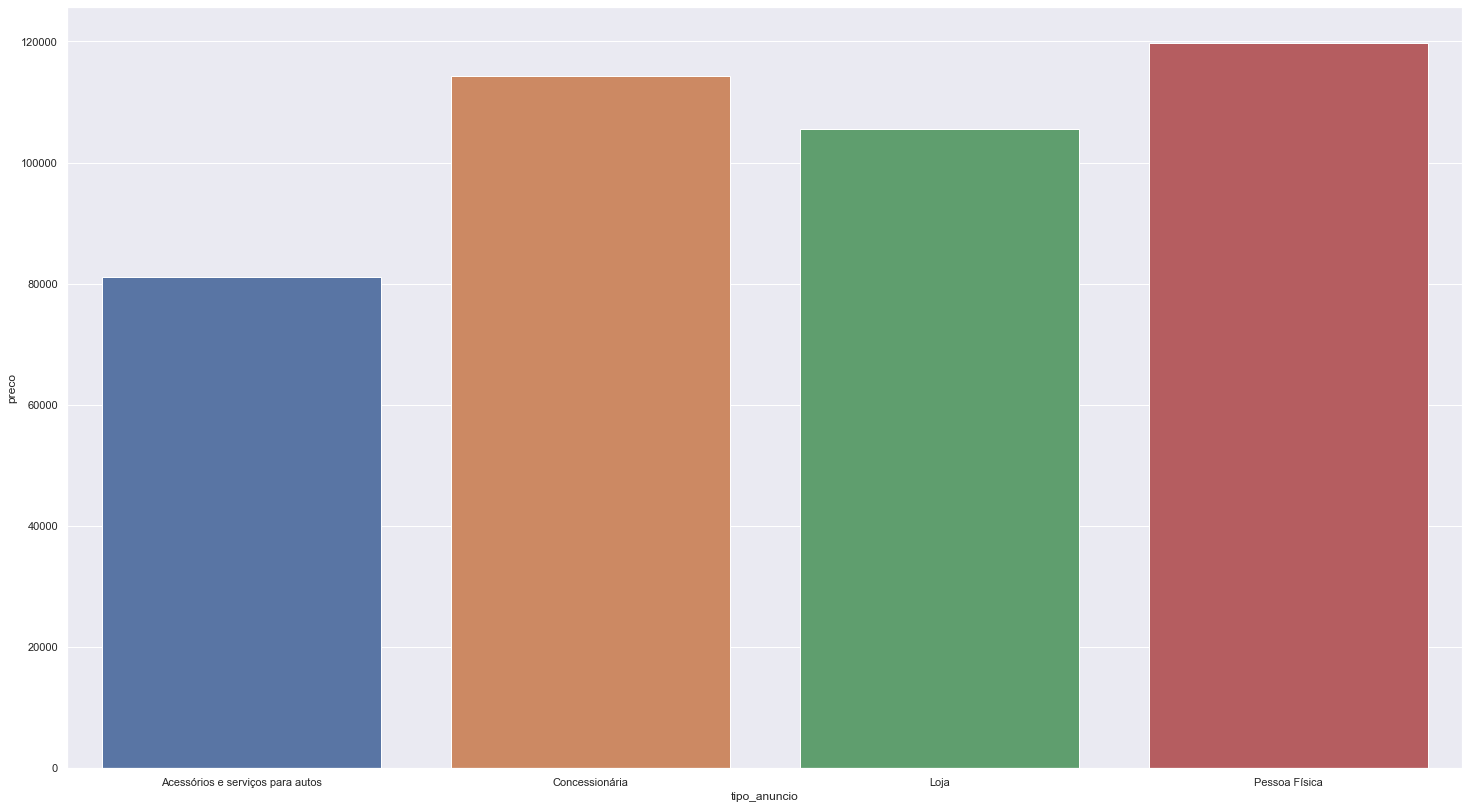

In [64]:
aux = df3[['preco', 'tipo_anuncio']].groupby('tipo_anuncio').median().reset_index()
sns.barplot(x='tipo_anuncio', y='preco', data=aux);

### 3.2.13 H13

- Carros com licenciamento pago tendem a ter um valor mais caro

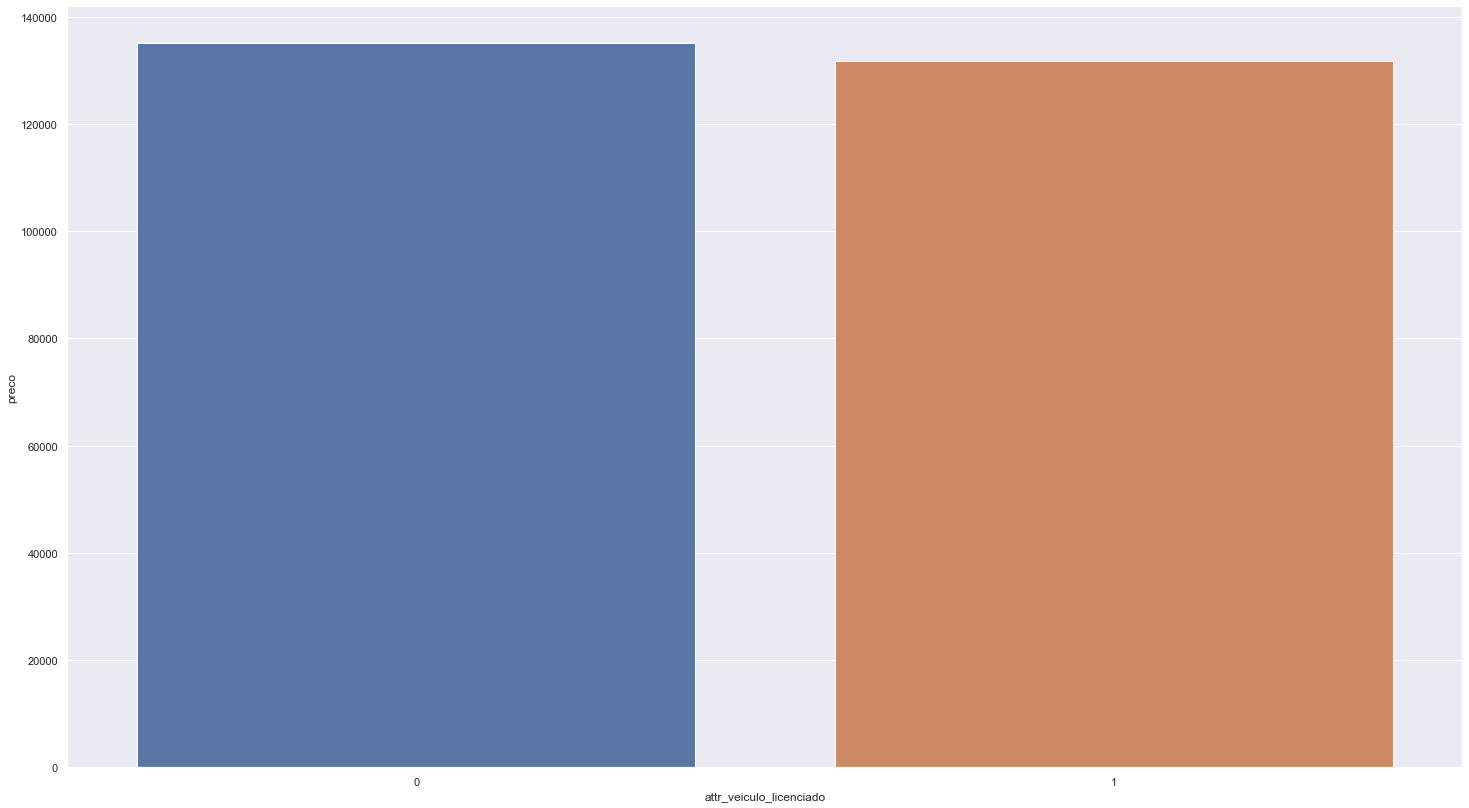

In [65]:
aux = df3[['preco', 'attr_veiculo_licenciado']].groupby('attr_veiculo_licenciado').mean().reset_index()
sns.barplot(x='attr_veiculo_licenciado', y='preco', data=aux);

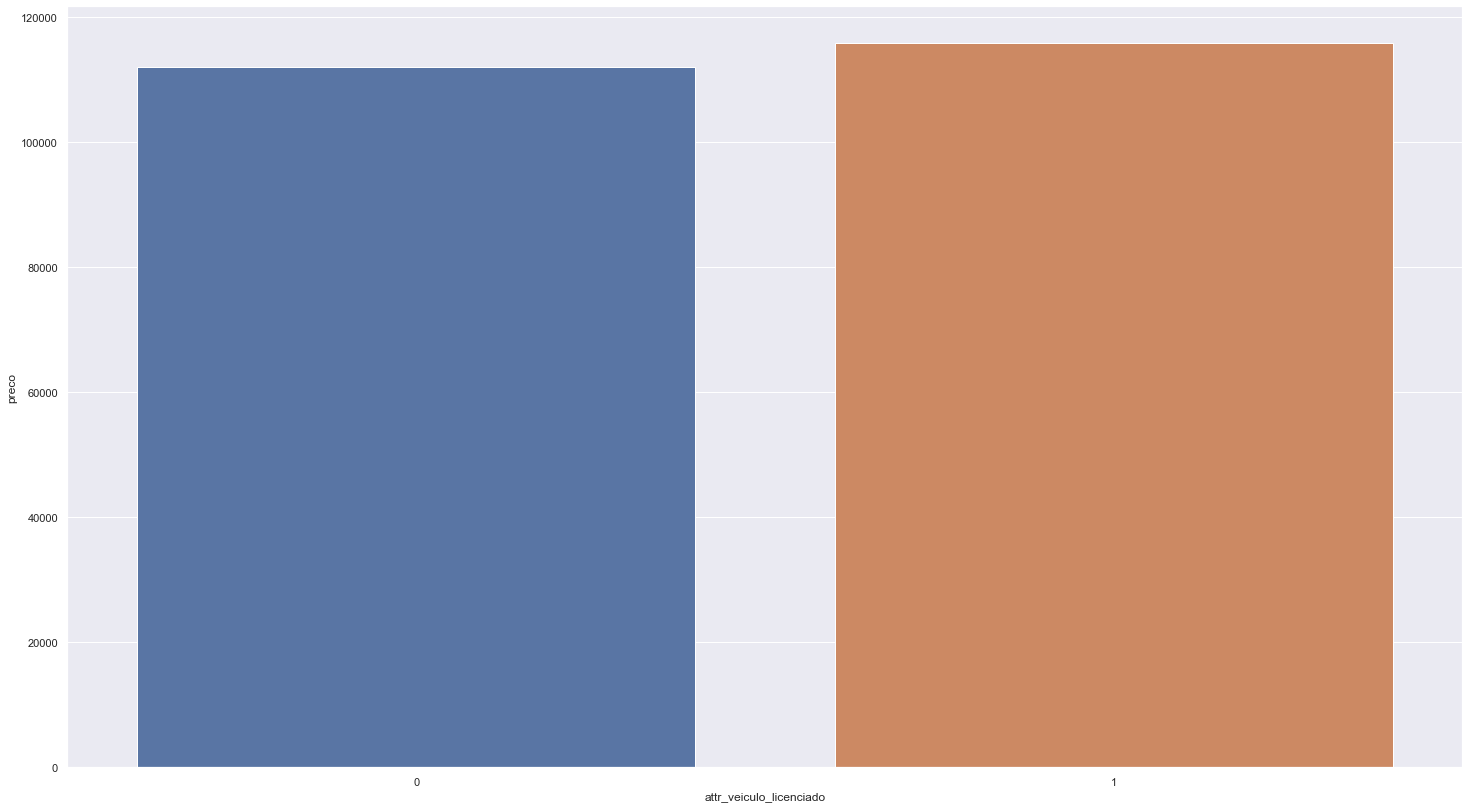

In [66]:
aux = df3[['preco', 'attr_veiculo_licenciado']].groupby('attr_veiculo_licenciado').median().reset_index()
sns.barplot(x='attr_veiculo_licenciado', y='preco', data=aux);

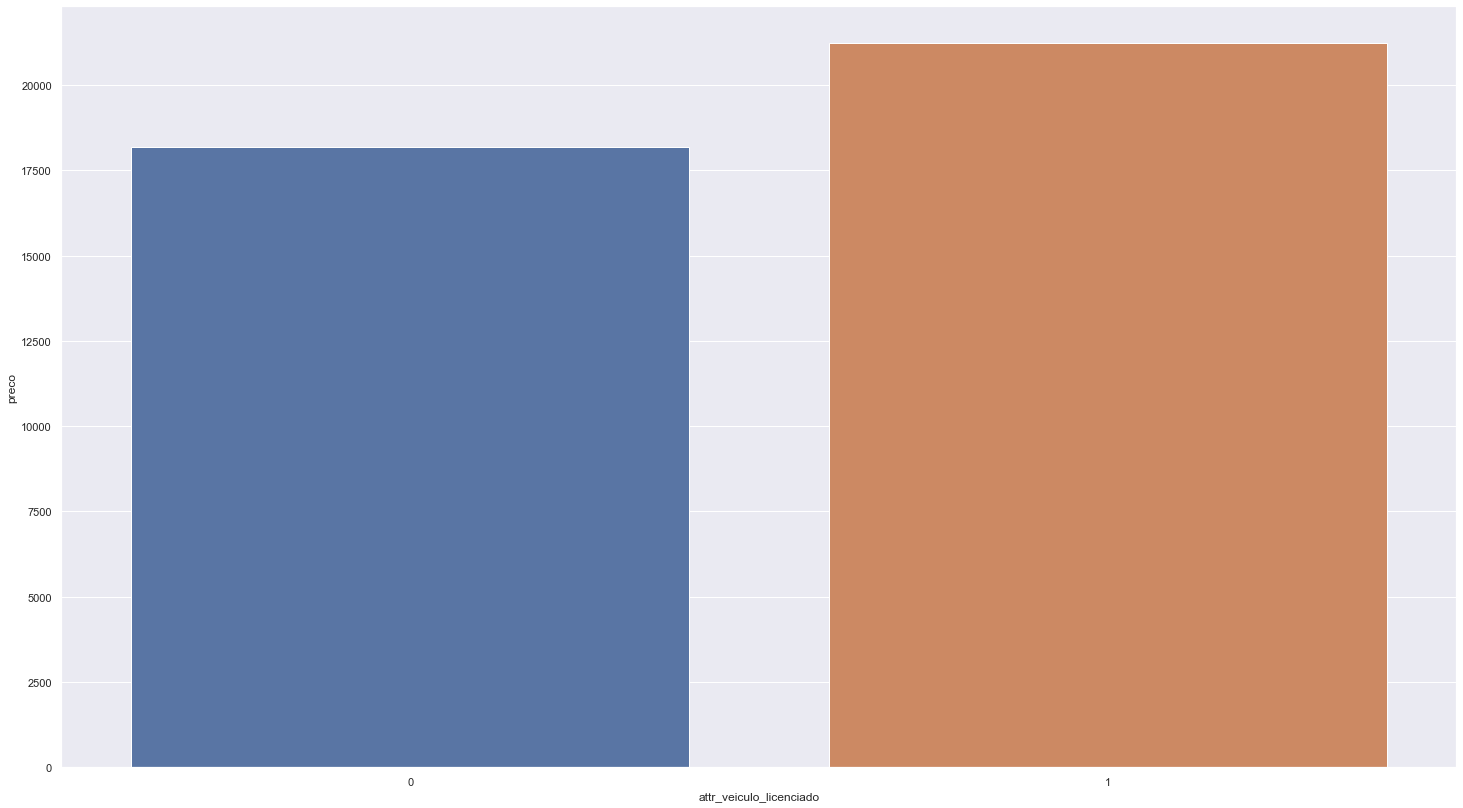

In [67]:
aux = df3[['preco', 'attr_veiculo_licenciado']].groupby('attr_veiculo_licenciado').count().reset_index()
sns.barplot(x='attr_veiculo_licenciado', y='preco', data=aux);

## 3.3 Análise Multivariada

In [68]:
num_attributes = df3.select_dtypes(include=['int64', 'float64'] )
cat_attributes = df3.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

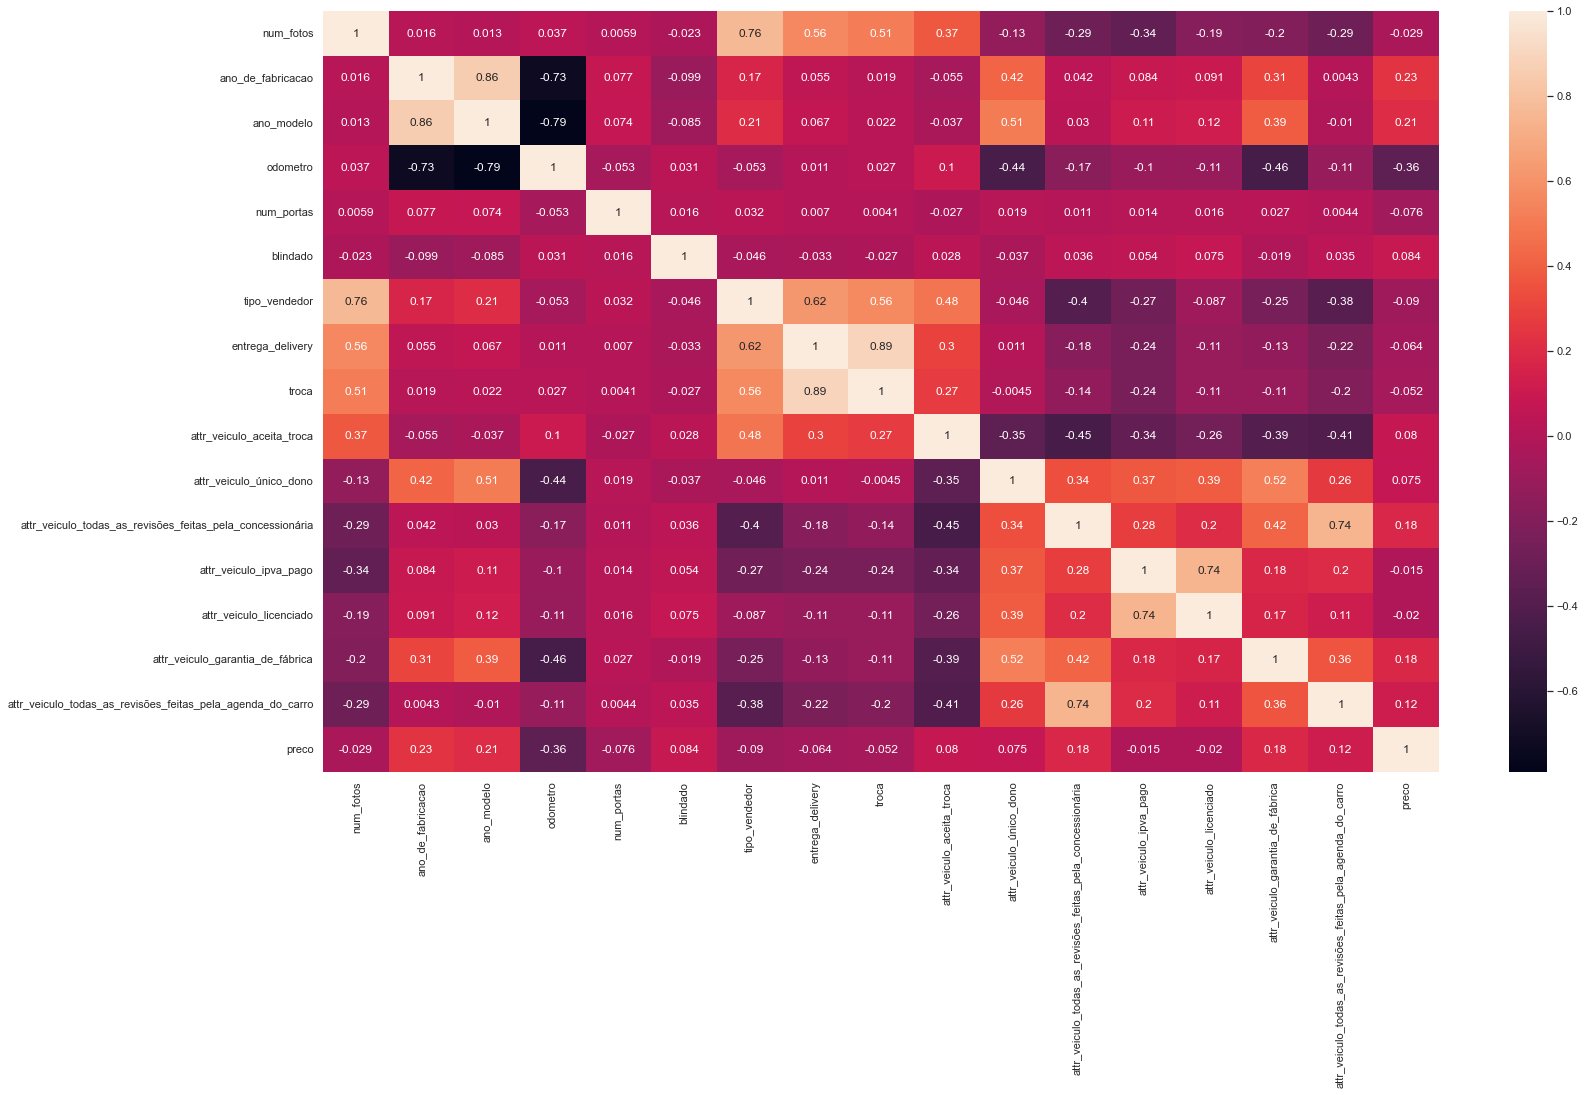

In [69]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 4.0 Data Preparation

In [20]:
df4 = df3.copy()

In [21]:
df_teste = pd.read_csv('teste.csv')

dff = pd.concat([df4, df_teste])

# fill na
df_teste['num_fotos'] = df_teste.apply(lambda x: 0 if math.isnan(x['num_fotos'])
                                       else x['num_fotos'], axis=1)
dff['num_fotos'] = dff.apply(lambda x: 0 if math.isnan(x['num_fotos'])
                             else x['num_fotos'], axis=1)




In [53]:
dff.isna().sum()

id                                                            39446
num_fotos                                                         0
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

In [22]:
rs = RobustScaler()
mms = MinMaxScaler()

rs = rs.fit(dff[['num_fotos']])
df4['num_fotos'] = rs.transform(df4[['num_fotos']].values)
df_teste['num_fotos'] = rs.transform(df_teste[['num_fotos']].values)

rs.fit(dff[['ano_de_fabricacao']])
df4['ano_de_fabricacao'] = rs.transform(df4[['ano_de_fabricacao']].values)
df_teste['ano_de_fabricacao'] = rs.transform(df_teste[['ano_de_fabricacao']].values)

rs.fit(dff[['ano_modelo']])
df4['ano_modelo'] = rs.transform(df4[['ano_modelo']].values)
df_teste['ano_modelo'] = rs.transform(df_teste[['ano_modelo']].values)

rs.fit(dff[['odometro']])
df4['odometro'] = rs.fit_transform(df4[['odometro']].values)
df_teste['odometro'] = rs.transform(df_teste[['odometro']].values)

df4['num_portas'] = mms.fit_transform(df4[['num_portas']].values)

In [74]:
df4['marca'].unique()

array(['VOLKSWAGEN', 'JAGUAR', 'CHEVROLET', 'PORSCHE', 'VOLVO', 'FIAT',
       'HYUNDAI', 'BMW', 'TOYOTA', 'RENAULT', 'PEUGEOT', 'JEEP', 'LEXUS',
       'MITSUBISHI', 'MERCEDES-BENZ', 'FORD', 'HONDA', 'AUDI', 'CITROËN',
       'MINI', 'NISSAN', 'LAND ROVER', 'RAM', 'KIA', 'TROLLER', 'SUBARU',
       'CHERY', 'SUZUKI', 'DODGE', 'BRM', 'CHRYSLER', 'LAMBORGHINI',
       'MASERATI', 'LIFAN', 'ALFA ROMEO', 'SMART', 'SSANGYONG', 'FERRARI',
       'JAC', 'EFFA', 'IVECO'], dtype=object)

In [75]:
dff.isna().sum()

id                                                            39446
num_fotos                                                         0
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

In [76]:
df4['marca'].isna().sum()

0

In [23]:
le = LabelEncoder()

#marca
le.fit(dff[['marca']].values)
df4['marca'] = le.transform( df4['marca'].values )
df_teste['marca'] = le.transform( df_teste['marca'].values )

#modelo
le.fit(dff[['modelo']].values)
df4['modelo'] = le.transform( df4['modelo'].values )
df_teste['modelo'] = le.transform( df_teste['modelo'].values )

#versao
le.fit(dff[['versao']].values)
df4['versao'] = le.transform( df4['versao'].values )
df_teste['versao'] = le.transform( df_teste['versao'].values )

#cambio
target_encode_cambio = df4.groupby( 'cambio' )['preco'].mean()
df4.loc[:, 'cambio'] = df4['cambio'].map( target_encode_cambio )
df_teste.loc[:, 'cambio'] = df_teste['cambio'].map( target_encode_cambio )

#tipo
target_encode_tipo = df4.groupby( 'tipo' )['preco'].mean()
df4.loc[:, 'tipo'] = df4['tipo'].map( target_encode_tipo )
df_teste.loc[:, 'tipo'] = df_teste['tipo'].map( target_encode_tipo )

#cor target enconder
target_encode_cor = df4.groupby( 'cor' )['preco'].mean()
df4.loc[:, 'cor'] = df4['cor'].map( target_encode_cor )
df_teste.loc[:, 'cor'] = df_teste['cor'].map( target_encode_cor )

#cidade_vendedor target enconder
le = le.fit(dff['cidade_vendedor'])
df4['cidade_vendedor'] = le.transform( df4['cidade_vendedor'] )
df_teste['cidade_vendedor'] = le.transform( df_teste['cidade_vendedor'] )

#estado_vendedor target enconder
target_encode_estado = df4.groupby( 'estado_vendedor' )['preco'].mean()
df4.loc[:, 'estado_vendedor'] = df4['estado_vendedor'].map( target_encode_estado )
df_teste.loc[:, 'estado_vendedor'] = df_teste['estado_vendedor'].map( target_encode_estado )

#tipo_anuncio
target_encode_anuncio = df4.groupby( 'tipo_anuncio' )['preco'].mean()
df4.loc[:, 'tipo_anuncio'] = df4['tipo_anuncio'].map( target_encode_anuncio )

In [78]:
df_teste.isna().sum()

ID                                                                0
num_fotos                                                         0
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               1
tipo_vendedor                                                     0
cidade_vendedor                                 

## 4.1 Validation Preparation

In [79]:
# x_validation.loc[:, 'num_fotos'] = rs.transform(x_validation[['num_fotos']].values)

# x_validation.loc[:, 'ano_de_fabricacao'] = rs.transform(x_validation[['ano_de_fabricacao']].values)

# x_validation.loc[:, 'ano_modelo'] = rs.transform(x_validation[['ano_modelo']].values)

# x_validation.loc[:, 'odometro'] = rs.transform(x_validation[['odometro']].values)

# x_validation.loc[:, 'num_portas'] = mms.transform(x_validation[['num_portas']].values)


# #marca
# x_validation.loc[:, 'marca'] = le.transform(x_validation[['marca']].values)

# #modelo
# x_validation.loc[:, 'modelo'] = le.transform(x_validation[['modelo']].values)

# #versao
# x_validation.loc[:, 'versao'] = le.transform(x_validation[['versao']].values)

# #cambio
# x_validation.loc[:, 'cambio'] = x_validation['cambio'].map( target_encode_cambio )

# #tipo
# x_validation.loc[:, 'tipo'] = x_validation['tipo'].map( target_encode_tipo )

# #cor target enconder
# x_validation.loc[:, 'cor'] = x_validation['cor'].map( target_encode_cor )

# #cidade_vendedor target enconder
# x_validation.loc[:, 'cidade_vendedor'] = le.transform(x_validation[['cidade_vendedor']].values)

# #estado_vendedor target enconder
# x_validation.loc[:, 'estado_vendedor'] = x_validation['estado_vendedor'].map( target_encode_estado )

# #tipo_anuncio
# x_validation.loc[:, 'tipo_anuncio'] = x_validation['tipo_anuncio'].map( target_encode_anuncio )

# 5 Feature Selection

In [24]:
df5 = df4.copy()

## 5.1 Feature Importance

In [25]:
# model definition
forest = en.RandomForestRegressor( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'preco'], axis=1 )
y_train_n = df5['preco']
forest.fit( x_train_n, y_train_n )

RandomForestRegressor(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                                             feature  importance
0                                             versao    0.323047
0                                           odometro    0.230483
0                                               tipo    0.086431
0                                             modelo    0.063432
0                                         ano_modelo    0.053876
0                                              marca    0.051211
0                                  ano_de_fabricacao    0.041259
0                                    cidade_vendedor    0.029843
0                                             cambio    0.022815
0                                    estado_vendedor    0.016956
0                                                cor    0.016598
0                                          num_fotos    0.012296
0                          attr_veiculo_aceita_troca    0.006214
0                                         num_portas    0.005295
0       

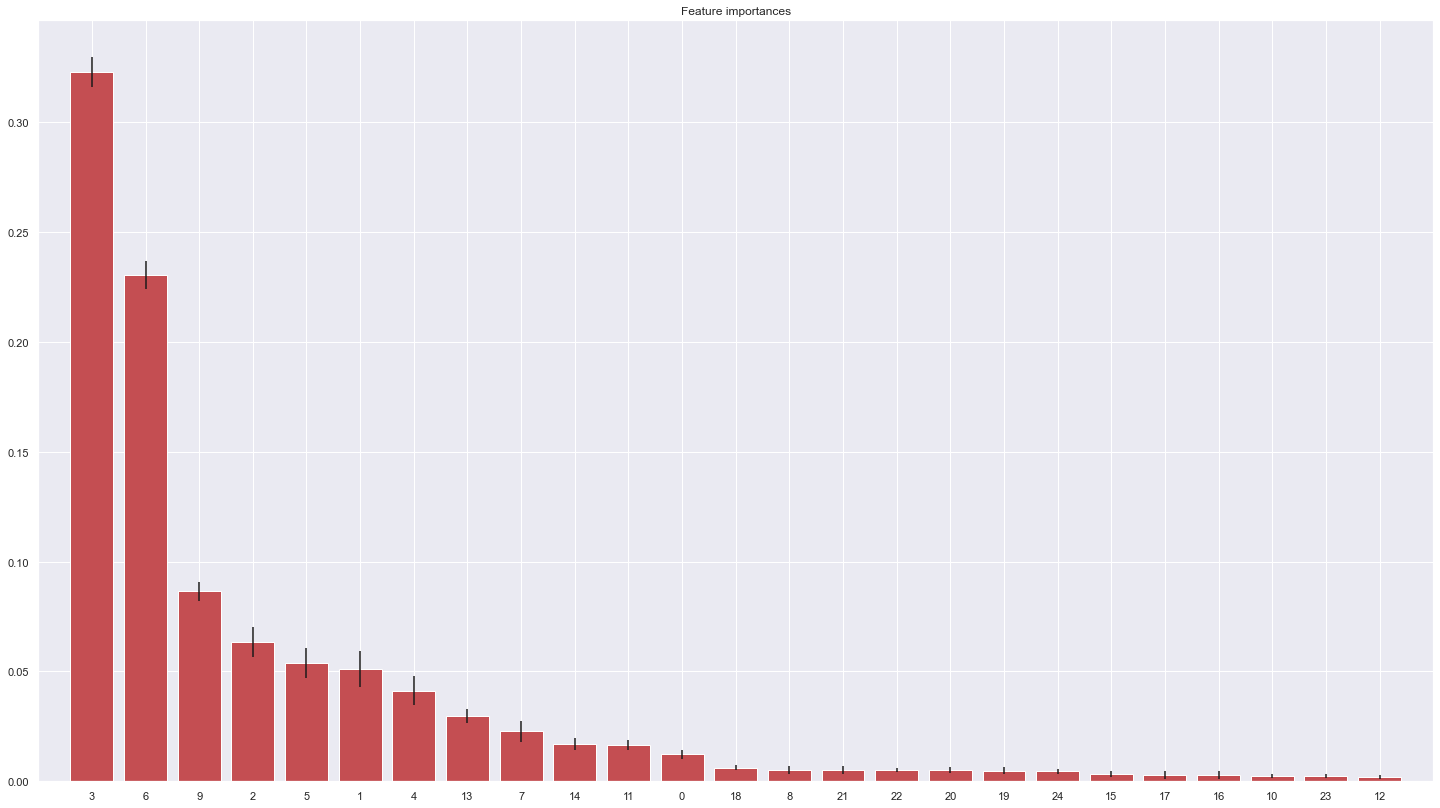

In [84]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 5.2 Feature selection

In [26]:
df5['preco'] = np.log1p(df5['preco'])


In [27]:
#df_teste['num_fotos'] = df_teste.apply(lambda x: 0 if math.isnan(x['num_fotos']) 
                             #else x['num_fotos'], axis=1)

df_teste['attr_veiculo_aceita_troca'].fillna(0, inplace=True)


df_teste['attr_veiculo_único_dono'].fillna(0, inplace=True)

df_teste['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].fillna(0, inplace=True)
                             
df_teste['attr_veiculo_ipva_pago'].fillna(0, inplace=True)
                             
df_teste['attr_veiculo_licenciado'].fillna(0, inplace=True)
                            
df_teste['attr_veiculo_garantia_de_fábrica'].fillna(0, inplace=True)

df_teste['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].fillna(0, inplace=True)

df_teste = df_teste.drop( ['attr_veiculo_alienado'], axis=1 )

In [28]:
df_teste.loc[:, 'attr_veiculo_único_dono'] = df_teste.loc[:,'attr_veiculo_único_dono'].map( {0: 0, 'Único dono': 1} ).astype('int64')

df_teste.loc[:, 'attr_veiculo_aceita_troca'] = df_teste.loc[:,'attr_veiculo_aceita_troca'].map( {0: 0, 'Aceita troca': 1} ).astype('int64')

df_teste.loc[:, 'attr_veiculo_aceita_troca'] = df_teste.loc[:,'attr_veiculo_aceita_troca'].map( {0: 0, 'Aceita troca': 1} ).astype('int64')


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [29]:
df_teste.columns


Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'],
      dtype='object')

In [79]:
cols_selected = ['versao', 'odometro', 'cidade_vendedor', 'modelo', 'ano_de_fabricacao', 
                 'ano_modelo', 'tipo_anuncio', 'estado_vendedor', 'marca', 'num_fotos', 'cor', 
                 'cambio']

cols_selected_full = ['versao', 'odometro', 'cidade_vendedor', 'modelo', 'ano_de_fabricacao', 
                      'ano_modelo', 'tipo_anuncio', 'estado_vendedor', 'marca', 'num_fotos', 'cor', 'preco', 
                      'cambio', 'attr_veiculo_aceita_troca', 'attr_veiculo_licenciado']

In [80]:
X = df5.drop( 'preco', axis=1 )
y = df5['preco'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [81]:
x_train = x_train[cols_selected]
x_validation = x_validation[cols_selected]

# 6.0 Machine Learning Modelling

In [82]:
df6 = df5[cols_selected_full]

## 6.2 Linear Regression

In [243]:
#model 
lr =  LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_validation)

#perfomance
lr_result = ml_error('Linear Regression', np.expm1(y_validation), np.expm1(yhat_lr))
lr_result

,Model Name,Mae,Mape,RMSE
0,Linear Regression,37922.097865,0.311254,58512.790311


In [230]:
lr_result_cv = cross_validation(df6, x_validation, y_validation, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,MAE CV,MAPE CV,RMSE CV
Linear Regression,36725.29 +/- 0.0,0.3 +/- 0.0,54454.55 +/- 0.0


## 6.3 Linear Regression Regularized Model

In [231]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_validation)

#perfomance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_validation), np.expm1(yhat_lrr))
lrr_result

,Model Name,Mae,Mape,RMSE
0,Linear Regression - Lasso,36876.188987,0.305136,54831.024381


In [40]:
lrr_result_cv = cross_validation(df6, x_validation, y_validation, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,MAE CV,MAPE CV,RMSE CV
Lasso,37605.5 +/- 0.0,0.31 +/- 0.0,58746.71 +/- 0.0


## 6.3 Random Forest Regressor

In [112]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_validation)

#perfomance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_validation), np.expm1(yhat_rf))
rf_result

,Model Name,Mae,Mape,RMSE
0,Random Forest Regressor,29050.772476,0.23974,49198.146637


In [95]:
rf_result_cv = cross_validation(df6, x_validation, y_validation, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
Random Forest Regressor,26855.36 +/- 0.0,0.21 +/- 0.0,45849.99 +/- 0.0


## 6.4 XGBoost Regressor

In [111]:
# model
model_xgb = xgb.XGBRegressor( n_estimators=100,
                              eta=0.3,
                              max_depth=6,
                              subsample=1,
                              colsample_bytree=1).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_validation)

#perfomance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_validation), np.expm1(yhat_xgb))
xgb_result

,Model Name,Mae,Mape,RMSE
0,XGBoost Regressor,28364.017288,0.231001,47330.82334


In [31]:
xgb_result_cv = cross_validation(df6, x_validation, y_validation, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
XGBoost,26453.01 +/- 0.0,0.21 +/- 0.0,41863.5 +/- 0.0


## 6.5 Extra Trees Regressor

In [110]:
reg = ExtraTreesRegressor(n_estimators=100, random_state = 0).fit( x_train, y_train )


#prediction
yhat_reg = reg.predict(x_validation)


#perfomance
reg_result = ml_error('Extra Trees', np.expm1(y_validation), np.expm1(yhat_reg))
reg_result

,Model Name,Mae,Mape,RMSE
0,Extra Trees,29770.478488,0.241918,50212.481267


In [99]:
reg_result_cv = cross_validation(df6, x_validation, y_validation, 5, 'Extra Trees', reg, verbose=True)
reg_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
Extra Trees,27590.94 +/- 0.0,0.22 +/- 0.0,46695.76 +/- 0.0


## 6.6 LightGBM

In [109]:
lgbm = LGBMRegressor(n_estimators=100).fit( x_train, y_train )

#prediction
yhat_lgbm = lgbm.predict(x_validation)


#perfomance
lgbm_result = ml_error('LightGBM', np.expm1(y_validation), np.expm1(yhat_lgbm))
lgbm_result

,Model Name,Mae,Mape,RMSE
0,LightGBM,28166.011589,0.228884,47627.903234


In [101]:
lgbm_result_cv = cross_validation(df6, x_validation, y_validation, 5, 'LightGBM', lgbm, verbose=True)
lgbm_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
LightGBM,27220.73 +/- 0.0,0.21 +/- 0.0,44936.16 +/- 0.0


## 6.7 XGBoost Tuned

### 6.7.1 GridSearch Tuned

In [62]:
from sklearn.model_selection import RandomizedSearchCV

In [63]:
from sklearn.model_selection import KFold

In [64]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [68]:
parameters = {'n_estimators': [150, 175, 250, 300, 500, 650, 750],
              'eta': [0.01, 0.03, 0.05],
              'max_depth': [2, 3, 5, 7, 9, 11],
              'subsample': [0.1, 0.5, 0.7],
              'colsample_bytree': [0.3, 0.7, 0.9],
              'min_child_weight': [3, 8, 12, 13, 15]}

gs = RandomizedSearchCV(model_xgb, param_distributions=parameters, cv=kf.split(X), scoring='neg_mean_absolute_error')
gs.fit(X,y)

maet = mean_absolute_error(y_train, gs.predict(x_train))
mae = mean_absolute_error(y_test, gs.predict(x_test))

print(f'MAE train set: {maet}, MAE test set: {mae}')

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\sklearn.py", line 931, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\sklearn.py", line 401, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\sklearn.py", line 945, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\core.py", line 643, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\data.py", line 896, in dispatch_data_backend
    return _from_pandas_df(data, enable_categorical, missing, threads,
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\data.py", line 345, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\data.py", line 283, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "C:\Users\kaka\anaconda3\envs\House_Price_Prediction\lib\site-packages\xgboost\data.py", line 247, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:id


### 6.7.2 Manually Tuned

In [62]:
param = {
    'n_estimators': [475, 480, 481, 482, 483, 485],
    'eta': [0.01, 0.03, 0.04, 0.05],
    'max_depth': [ 9,10, 11,12],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [10, 11, 12, 13]
}


MAX_EVAL = 5

In [206]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    #model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight']  )
    
    #perfomance
    result = cross_validation(df6, x_validation, y_validation, 10, 'XGBoost', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])
    

final_result

{'n_estimators': 483, 'eta': 0.01, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 13}

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 483, 'eta': 0.05, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 10}

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 485, 'eta': 0.05, 'max_depth': 10, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 10}

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 483, 'eta': 0.04, 'max_depth': 11, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 12}

KFold Numb

,MAE CV,MAPE CV,RMSE CV
XGBoost,29030.99 +/- 0.0,0.21 +/- 0.0,46785.59 +/- 0.0
XGBoost,25918.32 +/- 0.0,0.2 +/- 0.0,40722.67 +/- 0.0
XGBoost,26840.19 +/- 0.0,0.21 +/- 0.0,42328.43 +/- 0.0
XGBoost,25718.8 +/- 0.0,0.2 +/- 0.0,40510.74 +/- 0.0
XGBoost,27035.03 +/- 0.0,0.21 +/- 0.0,43130.72 +/- 0.0


## 6.8 LGBM Tuned

In [97]:
param = {
    'n_estimators': [100, 200, 350, 400, 450, 500],
    'max_depth': [2, 3, 5, 6, 7, 8, 11],
    'subsample': [0.8, 0.94, 0.98, 0.99],
    'colsample_bytree': [0.45, 0.48, 0.39, 0.35],
    'min_child_weight': [3, 4, 5, 6, 7, 8, 11, 12, 15]
}


MAX_EVAL = 25

In [98]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    #model
    model_lgbm = lgb.LGBMRegressor(n_estimators=hp['n_estimators'],
                                   max_depth=hp['max_depth'],
                                   subsample=hp['subsample'],
                                   colsample_bytree=hp['colsample_bytree'],
                                   min_child_weight=hp['min_child_weight']  )
    
    #perfomance
    result = cross_validation(df6, x_validation, y_validation, 15, 'XGBoost', model_lgbm, verbose=True)
    final_result = pd.concat([final_result, result])
    

final_result

{'n_estimators': 100, 'max_depth': 3, 'subsample': 0.3, 'colsample_bytree': 0.2, 'min_child_weight': 7}

KFold Number: 15

KFold Number: 14

KFold Number: 13

KFold Number: 12

KFold Number: 11

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 200, 'max_depth': 2, 'subsample': 0.2, 'colsample_bytree': 0.7, 'min_child_weight': 7}

KFold Number: 15

KFold Number: 14

KFold Number: 13

KFold Number: 12

KFold Number: 11

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 200, 'max_depth': 11, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 8}

KFold Number: 15

KFold Number: 14

KFold Number: 13

KFold Number: 12

KFold Number: 11

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold


KFold Number: 12

KFold Number: 11

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 200, 'max_depth': 11, 'subsample': 0.4, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 15

KFold Number: 14

KFold Number: 13

KFold Number: 12

KFold Number: 11

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 450, 'max_depth': 6, 'subsample': 0.4, 'colsample_bytree': 0.2, 'min_child_weight': 15}

KFold Number: 15

KFold Number: 14

KFold Number: 13

KFold Number: 12

KFold Number: 11

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
XGBoost,31190.51 +/- 0.0,0.25 +/- 0.0,49468.37 +/- 0.0
XGBoost,30675.17 +/- 0.0,0.25 +/- 0.0,47829.25 +/- 0.0
XGBoost,26442.38 +/- 0.0,0.21 +/- 0.0,41770.69 +/- 0.0
XGBoost,25893.31 +/- 0.0,0.2 +/- 0.0,40935.29 +/- 0.0
XGBoost,27195.45 +/- 0.0,0.22 +/- 0.0,42561.45 +/- 0.0
XGBoost,26442.38 +/- 0.0,0.21 +/- 0.0,41770.69 +/- 0.0
XGBoost,26776.23 +/- 0.0,0.21 +/- 0.0,42194.94 +/- 0.0
XGBoost,26523.63 +/- 0.0,0.21 +/- 0.0,41806.83 +/- 0.0
XGBoost,26427.36 +/- 0.0,0.21 +/- 0.0,42145.28 +/- 0.0
XGBoost,30432.95 +/- 0.0,0.24 +/- 0.0,47909.75 +/- 0.0


In [99]:
param_tuned = {
    'n_estimators': 400,
    'max_depth':7,
    'subsample': 0.2,
    'colsample_bytree': 0.7,
    'min_child_weight': 4
    
}



# model
model_lgb_tuned = lgb.LGBMRegressor( n_estimators=param_tuned['n_estimators'],
                                     max_depth=param_tuned['max_depth'],
                                     subsample=param_tuned['subsample'],
                                     colsample_bytree=param_tuned['colsample_bytree'],
                                     min_child_weight=param_tuned['min_child_weight']  ).fit(x_train, y_train)

#prediction
yhat_lgb_tuned = model_lgb_tuned.predict(x_validation)


#perfomance
lgb_result_tuned = ml_error('LGBM Regressor', np.expm1(y_validation), np.expm1(yhat_xgb_tuned))
lgb_result_tuned

,Model Name,Mae,Mape,RMSE
0,LGBM Regressor,25747.871166,0.202086,41069.226224


In [100]:
df7 = df_teste[cols_selected]

yhat_final = model_lgb_tuned.predict(df7)

df7['preco'] = np.expm1(yhat_final)

df7['ID'] = df_teste['ID']

final = df7[['ID', 'preco']]

final.to_csv('final_4.csv', index=False)

# 7 Final Model

In [244]:
df7 = df_teste[cols_selected]

yhat_final = model_xgb_tuned.predict(df7)

In [245]:
df7['preco'] = np.expm1(yhat_final)

df7['ID'] = df_teste['ID']

In [202]:
df7.head()

,versao,odometro,cidade_vendedor,modelo,ano_de_fabricacao,ano_modelo,tipo,estado_vendedor,marca,num_fotos,cor,cambio,preco,ID
0,954,0.112930,573,417,-0.2,-0.25,118647.979849,134702.989305,5,1.000000,130548.873396,146579.444142,63583.035156,24813264385557040124808779273028388499
1,889,-0.609986,700,443,0.6,0.75,159605.703146,130172.754418,11,0.000000,130548.873396,146579.444142,115903.898438,295636316453795508942188530111300065666
2,22,-0.399335,700,349,0.2,0.50,92666.521106,130172.754418,40,0.000000,130548.873396,146579.444142,87847.875000,101258309166227950735244624080888109884
3,979,0.582308,594,446,-1.2,-0.75,118647.979849,133680.053381,5,1.166667,130548.873396,146579.444142,79352.945312,28348734455782469411126661985772047409
4,1116,0.706158,130,2,-0.6,-0.25,118647.979849,142683.743177,2,0.000000,130548.873396,146579.444142,117596.835938,193163160502972147671913739170248305797


In [246]:
final = df7[['ID', 'preco']]

In [247]:
final.to_csv('final_16.csv', index=False)

In [248]:
final.head()

,ID,preco
0,24813264385557040124808779273028388499,59350.906250
1,295636316453795508942188530111300065666,114464.242188
2,101258309166227950735244624080888109884,86538.625000
3,28348734455782469411126661985772047409,78550.679688
4,193163160502972147671913739170248305797,107935.179688


In [116]:
param_tuned = {
    'n_estimators': 350,
    'eta': 0.05,
    'max_depth':11,
    'subsample': 0.7,
    'colsample_bytree': 0.3,
    'min_child_weight': 11
    
}



# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight']  ).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_validation)


#perfomance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_validation), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,Mae,Mape,RMSE
0,XGBoost Regressor,25654.054312,0.201241,40903.166866
